In [2]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from math import isnan, log
from scipy.stats import linregress
import matplotlib.dates as mdates

In [3]:
###### remove extraneous data from the CDC Excess Deaths data set and add the mid-point of excess deaths estimate ######

# Import CDC excess deaths data from file
xs_deaths = pd.read_csv("data/xs_deaths.csv")

# The CDC data has three entries for each state for each week. These represent whether they are Type "Predicted(weighted)" or "Unweighted" and Outcome "All causes"
# or "All causes, excluding COVID-19". For this analysis I onlly want the "Predicte(weighted)" and "All causes, excluding COVID-19". 
# Droping Type "All causes" solves that problem
xs_deaths.drop(xs_deaths[(xs_deaths['Outcome'] == 'All causes')].index , inplace=True)

# change the "date" to datetime type
xs_deaths['Week Ending Date'] =  pd.to_datetime(xs_deaths['Week Ending Date'])

#capture the lastest date of the CDC data - used later for getting avg of most recent excess deaths
latest_date_of_cdc_data = xs_deaths['Week Ending Date'].max()

# Drop PR and the "all US" data
indexNames = xs_deaths[ (xs_deaths['State'] == 'Puerto Rico') | 
                        (xs_deaths['State'] == 'United States')].index

xs_deaths.drop(indexNames , inplace=True) 

# Select only values that match the time period for the JHU data
xs_deaths_2020 = xs_deaths[(xs_deaths['Week Ending Date'] > '2020-01-21')].copy()
del xs_deaths

# drop the unnecessary columns 
xs_deaths_2020 = xs_deaths_2020.drop(xs_deaths_2020.columns[[2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, 16]], axis=1)

# add the average of the upper and lower xs deaths to the df
xs_deaths_2020['mid_point_xs_deaths'] = (xs_deaths_2020['Excess Lower Estimate'] + xs_deaths_2020['Excess Higher Estimate'])/2

# rename columns
xs_deaths_2020.rename(columns={"Week Ending Date": "date", "State":"state"}, inplace=True)

## merge the NYC city with the NY state data (CDC had the data broken out separately) ##
# merge the data
ny_data = xs_deaths_2020.loc[xs_deaths_2020['state'].str.contains('New York')].groupby('date').sum()

# Add a new 'state' column for merging back with the xs_deaths_2020 df
ny_data['state'] = 'New York'
ny_data.reset_index(inplace=True)

# change the order of the columns (probably delete this later)
ny_data = ny_data[['date', 'state', 'Excess Lower Estimate', 'Excess Higher Estimate', 'mid_point_xs_deaths']]

# drop the NY and NYC data from the xs_deaths_2020 df
xs_deaths_2020.drop(xs_deaths_2020[xs_deaths_2020['state'].str.contains('New York')].index , inplace=True)

# concatenate xs_death_2020 and ny_data so the df has all NY (NYC and NY state) data as NY state
dfs_to_concat = [xs_deaths_2020, ny_data]
xs_deaths_2020_ny = pd.concat(dfs_to_concat)
del xs_deaths_2020
del ny_data

# sort the data to be tidy :-)
xs_deaths_2020_ny.sort_values(by=['state','date'], inplace=True)
xs_deaths_2020_ny.reset_index(inplace=True)
del xs_deaths_2020_ny['index']

###### end/remove extraneous data from the CDC Excess Deaths data set ######




###### munge JHU data, remove extraneous data, and add 7-day rolling averages ######

# import data files
new_cases = pd.read_csv("data/jhu_confirmed_daily.csv")
new_deaths = pd.read_csv("data/jhu_deaths_daily.csv")

# drop the following columns because they aren't important to this analysis
new_cases.drop(["UID", "iso2", "iso3", "code3", "FIPS", "Country_Region", "Lat", "Long_", "Combined_Key"], axis=1, inplace=True)
new_deaths.drop(["UID", "iso2", "iso3", "code3", "FIPS", "Country_Region", "Lat", "Long_", "Combined_Key", "Population"], axis=1, inplace=True)

# melt into a long form instead of wide
new_cases_long = new_cases.melt(id_vars=["Admin2", "Province_State"], var_name="Date", value_name="New_Cases")
new_deaths_long = new_deaths.melt(id_vars=["Admin2", "Province_State"], var_name="Date", value_name="Deaths")
del new_cases
del new_deaths

# convert the date column from a string into datetime
new_cases_long['Date'] = pd.to_datetime(new_cases_long['Date'])
new_deaths_long['Date'] = pd.to_datetime(new_deaths_long['Date'])

## JHU data is at the county level - sum all the data from counties into state level ##
# groupby/sum - from https://jamesrledoux.com/code/group-by-aggregate-pandas
# output -> index, Province_State, Date, new_cases
new_cases_by_state = new_cases_long.groupby(['Province_State','Date']).agg({'New_Cases':['sum']})
del new_cases_long
new_cases_by_state.columns = ['new_cases']
new_cases_by_state = new_cases_by_state.reset_index()
new_cases_by_state.sort_values(['Province_State','Date'], inplace=True)

# output -> index, Province_State, Date, new_deaths
new_deaths_by_state = new_deaths_long.groupby(['Province_State','Date']).agg({'Deaths':['sum']})
del new_deaths_long
new_deaths_by_state.columns = ['new_deaths']
new_deaths_by_state = new_deaths_by_state.reset_index()
new_deaths_by_state.sort_values(['Province_State','Date'], inplace=True)

# replacing the administrative corrections that cause an artificial bump in NJ's deaths on 6/25/20
# https://kywnewsradio.radio.com/articles/news/new-jersey-now-reporting-probable-covid-19-deaths

new_deaths_by_state_fixed = new_deaths_by_state.copy()
del new_deaths_by_state

deaths_NJ_6_24 = new_deaths_by_state_fixed['new_deaths'].loc[(new_deaths_by_state_fixed['Province_State'] == 'New Jersey') & 
                                      (new_deaths_by_state_fixed['Date'] == '2020-06-24')].values[0]

deaths_NJ_6_25 = new_deaths_by_state_fixed['new_deaths'].loc[(new_deaths_by_state_fixed['Province_State'] == 'New Jersey') & 
                                      (new_deaths_by_state_fixed['Date'] == '2020-06-25')].values[0]

deaths_NJ_6_26 = new_deaths_by_state_fixed['new_deaths'].loc[(new_deaths_by_state_fixed['Province_State'] == 'New Jersey') & 
                                      (new_deaths_by_state_fixed['Date'] == '2020-06-26')].values[0]

substitution_value = ((deaths_NJ_6_24+deaths_NJ_6_26)/2)

new_deaths_by_state_fixed.loc[(new_deaths_by_state_fixed['Province_State'] == 'New Jersey') & 
                                      (new_deaths_by_state_fixed['Date'] == '2020-06-25'), 'new_deaths'] = substitution_value

del deaths_NJ_6_26

# # add a column of a 7-day rolling average to daily cases and deaths
# new_cases_by_state['new_cases_rollavg'] = (new_cases_by_state.groupby('Province_State')
#                                                             .rolling(7)['new_cases']
#                                                             .mean()
#                                                             .reset_index(drop=True))

# new_deaths_by_state_fixed['new_deaths_rollavg'] = (new_deaths_by_state_fixed.groupby('Province_State')
#                                                                 .rolling(7)['new_deaths']
#                                                                 .mean()
#                                                                 .reset_index(drop=True))

# Outer Join of the daily_cases and daily_deaths tables
combined_daily_cases_deaths = pd.merge(new_cases_by_state,new_deaths_by_state_fixed,on=['Province_State','Date'],how='outer')
del new_cases_by_state
del new_deaths_by_state_fixed

# drop Diamond Princess, Guam, American Somoa, Northern Mariana Islands, and Puerto Rico (other data sets don't have the territories)
combined_daily_cases_deaths.drop(combined_daily_cases_deaths.loc[combined_daily_cases_deaths['Province_State'] == "Diamond Princess"].index, inplace=True)
combined_daily_cases_deaths.drop(combined_daily_cases_deaths.loc[combined_daily_cases_deaths['Province_State'] == "Grand Princess"].index, inplace=True)
combined_daily_cases_deaths.drop(combined_daily_cases_deaths.loc[combined_daily_cases_deaths['Province_State'] == "American Samoa"].index, inplace=True)
combined_daily_cases_deaths.drop(combined_daily_cases_deaths.loc[combined_daily_cases_deaths['Province_State'] == "Guam"].index, inplace=True)
combined_daily_cases_deaths.drop(combined_daily_cases_deaths.loc[combined_daily_cases_deaths['Province_State'] == "Northern Mariana Islands"].index, inplace=True)
combined_daily_cases_deaths.drop(combined_daily_cases_deaths.loc[combined_daily_cases_deaths['Province_State'] == "Puerto Rico"].index, inplace=True)
combined_daily_cases_deaths.drop(combined_daily_cases_deaths.loc[combined_daily_cases_deaths['Province_State'] == "Virgin Islands"].index, inplace=True)

# save the processed data as a csv (for use by other applications such as the Streamlit webapp)
combined_daily_cases_deaths.to_csv("data/daily_cases_deaths.csv", index=False)

###### end/munge JHU data, remove extraneous data, and add 7-day rolling averages ######





###### create a table of the JHU data summed into weekly values instead of daily and merge with CDC excess deaths data ######

# # drop the rolling averages, they're not necessary for the weekly sums data
# daily_cases_deaths = combined_daily_cases_deaths.drop(combined_daily_cases_deaths.columns[[3, 5]], axis=1)
# del combined_daily_cases_deaths

daily_cases_deaths = combined_daily_cases_deaths
del combined_daily_cases_deaths

# rename columns because I prefer this convention
daily_cases_deaths.rename(columns={"Province_State": "state", "Date": "date", "new_cases": "new_cases_jhu", "new_deaths":"new_deaths_jhu"}, inplace=True)

# sum the weekly cases, match the week starting date to the one used by the CDC
weekly_cases_deaths = daily_cases_deaths.groupby('state').resample('W-SAT', on='date').sum()
weekly_cases_deaths['new_deaths_jhu'] = weekly_cases_deaths['new_deaths_jhu'].astype(int)

# delete the lastest week if it's not a complete week
latest_date_of_jhu_data = daily_cases_deaths['date'].max()

# reset the index so 'date' is a column
weekly_cases_deaths.reset_index(inplace=True)

if latest_date_of_jhu_data.weekday() != 5:
    latest_date_of_weekly_cases_deaths = weekly_cases_deaths['date'].max()
    weekly_cases_deaths = weekly_cases_deaths[weekly_cases_deaths.date != latest_date_of_weekly_cases_deaths]

# free memory
del daily_cases_deaths

# merge the CDC weekly excess deaths with the JMU deaths data
weekly_cases_deaths_xs = pd.merge(weekly_cases_deaths, xs_deaths_2020_ny, how='left', left_on=['state','date'], right_on=['state','date']) 

###### end/group the JHU data into weekly values instead of daily ######

###### get the average of the last 4 values mid_point_xs_deaths

select_back_to = latest_date_of_cdc_data - timedelta(weeks=4) # this gives the date of the 5th week back

# select only the latest 4 weeks of data from the CDC excess deaths data
latest_weeks_xs_deaths = weekly_cases_deaths_xs[(weekly_cases_deaths_xs['date'] > select_back_to) & 
                                                (weekly_cases_deaths_xs['date'] <= latest_date_of_cdc_data)].copy()

# average the latest 4 weeks data
latest_weeks_xs_deaths_avg = latest_weeks_xs_deaths.groupby('state').mean()

latest_weeks_xs_deaths_avg = latest_weeks_xs_deaths_avg.fillna(0)

/Users/robbdunlap/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# convert the results to integers (rounds down)
latest_weeks_xs_deaths_avg = latest_weeks_xs_deaths_avg.astype(int)

In [5]:
# add the dates to indicate what date range the averages were taken from
latest_weeks_xs_deaths_avg['data_from_dates_after'] = select_back_to
latest_weeks_xs_deaths_avg['data_from_dates_up_to'] = latest_date_of_cdc_data

# reset the index
latest_weeks_xs_deaths_avg.reset_index(inplace=True)

###### end/get the average of the last 4 values mid_point_xs_deaths ######




###### calculating estimated actual deaths per day from CDC xs deaths and JHU reported deaths data ######

# create a dictionary of the mid_point_xs_deaths to make calculation quicker in the df
state_xs_deaths_dict = latest_weeks_xs_deaths_avg.set_index('state').to_dict()['mid_point_xs_deaths']

# function to calculate the reported + excess deaths - use value if exists for date, otherwise use 
# average of last 4 weeks of reported data

# the old version that didn't work well for states will low deaths
# def est_deaths(row):
#     if row['date'] <= latest_date_of_cdc_data:
#         corrected_value = row.fillna(0)['new_deaths_jhu'] + row.fillna(0)['mid_point_xs_deaths']
#     else:
#         corrected_value = row.fillna(0)['new_deaths_jhu'] + state_xs_deaths_dict[row['state']]
#     return corrected_value

# the new-improved version that doesn't estimate excess deaths for when a state has less than
# 6 deaths that week. Instead, it just uses the JHU reported deaths value and doesn't make a
# correction.
def est_deaths(row):
    if row['new_deaths_jhu'] < 6:
        corrected_value = row.fillna(0)['new_deaths_jhu']
    elif row['date'] <= latest_date_of_cdc_data:
        corrected_value = row.fillna(0)['new_deaths_jhu'] + row.fillna(0)['mid_point_xs_deaths']
    else:
        corrected_value = row.fillna(0)['new_deaths_jhu'] + state_xs_deaths_dict[row['state']]
    return corrected_value

# apply the calculation to each row
weekly_cases_deaths_xs['corr_new_deaths'] = weekly_cases_deaths_xs.apply(est_deaths, axis=1)

# save the data as a csv for the other modules
weekly_cases_deaths_xs.to_csv("data/weekly_cases_deaths_xs.csv", index=False)

###### end/calculating estimated actual deaths per day from CDC xs deaths and JHU reported deaths data ######

In [6]:
weekly_cases_deaths_xs.tail()

state       date  new_cases_jhu  new_deaths_jhu  \
2392  Wyoming 2020-11-14           5284              30   
2393  Wyoming 2020-11-21           5529              32   
2394  Wyoming 2020-11-28           4518              39   
2395  Wyoming 2020-12-05           4013              51   
2396  Wyoming 2020-12-12           2966              55   

      Excess Lower Estimate  Excess Higher Estimate  mid_point_xs_deaths  \
2392                    0.0                     5.0                  2.5   
2393                    0.0                     4.0                  2.0   
2394                    0.0                     0.0                  0.0   
2395                    NaN                     NaN                  NaN   
2396                    NaN                     NaN                  NaN   

      corr_new_deaths  
2392             32.5  
2393             34.0  
2394             39.0  
2395             53.0  
2396             57.0

In [7]:
###### add the estimated infections that occured 2 weeks previous to the date of the corrected deaths ######

est_infections = weekly_cases_deaths_xs[['state', 'date','corr_new_deaths']].copy()

est_infections['offset_date'] = est_infections['date'] - timedelta(weeks=2)

# this is the inverse of the estimated infection fatality ratio - taken from literature
# https://www.medrxiv.org/content/10.1101/2020.05.03.20089854v4
# https://www.cdc.gov/coronavirus/2019-ncov/hcp/planning-scenarios.html
estimated_ifr = 1/0.0068

est_infections['est_inf'] = est_infections['corr_new_deaths'] * estimated_ifr
est_infections['est_inf'] = est_infections['est_inf'].astype(int)

In [8]:
est_infections.tail()

state       date  corr_new_deaths offset_date  est_inf
2392  Wyoming 2020-11-14             32.5  2020-10-31     4779
2393  Wyoming 2020-11-21             34.0  2020-11-07     5000
2394  Wyoming 2020-11-28             39.0  2020-11-14     5735
2395  Wyoming 2020-12-05             53.0  2020-11-21     7794
2396  Wyoming 2020-12-12             57.0  2020-11-28     8382

In [9]:
# drop estimated infections before the start of the JHU dataset - not critical, just because
est_infections.drop(est_infections[est_infections['offset_date'] < '2020-01-22'].index , inplace=True)

# drop rows that were used to generate data but are not needed in the merge
est_infections.drop(['date', 'corr_new_deaths'], axis = 1, inplace=True) 

# merge the estimate infections back with weekly_cases_deaths_xs. This will result
# in nan values for the lastest two weeks. This method back-calculates the estimated 
# number of infections that had to have occured to cause the specified number of deaths,
# therefore the latest two weeks will have nan values. These values will be filled in 
# as time proceeds.
weekly_est_cases_deaths = weekly_cases_deaths_xs.merge(est_infections, 
                                                       left_on=['state','date'], 
                                                       right_on=['state','offset_date'],
                                                       how='outer')

###### end/add the estimated infections that occured 2 weeks previous to the date of the corrected deaths ######

In [10]:
est_infections.tail()

state offset_date  est_inf
2392  Wyoming  2020-10-31     4779
2393  Wyoming  2020-11-07     5000
2394  Wyoming  2020-11-14     5735
2395  Wyoming  2020-11-21     7794
2396  Wyoming  2020-11-28     8382

In [11]:
###### add percent change in weekly est_inf ######

def per_change_est_cases_func(rows):
    # temporarily set panda options so that values with "divide by 0" are converted to nan instead of infinity
    with pd.option_context('mode.use_inf_as_na', True):
        rows['pro_chg_est_inf'] = (rows['est_inf'] - rows['est_inf'].shift(1)) / rows['est_inf'].shift(1)    
        return rows

weekly_est_cases_deaths = weekly_est_cases_deaths.groupby('state').apply(per_change_est_cases_func)
weekly_est_cases_deaths['pro_chg_est_inf'] = weekly_est_cases_deaths['pro_chg_est_inf'].round(4)

###### end/add percent change in weekly est_inf ######


###### calculating the estimated proportion of the population that has already been infected with COVID-19 ######

# remove the last 2 weeks of data for each state because we don't have estimated infections for those dates
max_date_est_inf = weekly_est_cases_deaths['offset_date'].max()
trimed_last_2_wks = weekly_est_cases_deaths[(weekly_est_cases_deaths['date'] <= max_date_est_inf)]

sum_infections = trimed_last_2_wks.groupby('state')['est_inf','new_cases_jhu'].sum().astype('int32')

# add state population data
state_pop = pd.read_csv('data/state_pop.csv')

percent_pop_infected = state_pop.merge(sum_infections, left_on="NAME", right_on="state")
percent_pop_infected['est_proportion_infected'] = (percent_pop_infected['est_inf'] /
                                              percent_pop_infected['POPESTIMATE2019'])
percent_pop_infected['rep_proportion_infected'] = (percent_pop_infected['new_cases_jhu'] /
                                              percent_pop_infected['POPESTIMATE2019'])

percent_pop_infected.sort_values(by=['est_proportion_infected'], ascending=False, inplace=True)
percent_pop_infected.rename(columns={"NAME": "state", "POPESTIMATE2019": "2019_pop", "est_inf":"sum_est_inf", "new_cases_jhu":"sum_new_cases_jhu"}, inplace=True)

total_pop = percent_pop_infected['2019_pop'].sum()
total_infected = percent_pop_infected['sum_est_inf'].sum()
total_reported_infected = percent_pop_infected['sum_new_cases_jhu'].sum()

percent_total_us_pop_est_infected = f"{100*total_infected/total_pop:.1f}"
percent_total_us_pop_reported_infected = f"{100*total_reported_infected/total_pop:.1f}"

# from https://worldpopulationreview.com/states/state-abbreviations
state_abbrevs = pd.read_csv('data/state_abbrevs.csv')

def add_state_id(row):
    state = row['state']
    state_id = state_abbrevs[state_abbrevs['State'] == state]['Code']
    return state_id.values[0]
    
percent_pop_infected['state_id'] =  percent_pop_infected.apply(add_state_id, axis=1)

latest_date_of_estimate = str(max_date_est_inf)[:10]
date_of_reporting = str(latest_date_of_jhu_data)[:10]

# drop the offset date column
del weekly_est_cases_deaths['offset_date']


print(f'Latest date of entry in JHU data {date_of_reporting}\n')
print('Estimated total percent of the US population that')
print(f'has been infected by COVID-19 as of {latest_date_of_estimate}:      '+str(percent_total_us_pop_est_infected)+'%\n')
print('Reported total percent of the US population that')
print(f'has been infected by COVID-19 as of {latest_date_of_estimate}:      '+str(percent_total_us_pop_reported_infected)+'%\n')
print(f'Propotion of population in all states that have been infected as of {latest_date_of_estimate} (reverse rank ordered)')
print('-----------------------------------------------------------------------------------------------------')
percent_pop_infected

###### end/calculating the estimated proportion of the population that has already been infected with COVID-19 ######

Latest date of entry in JHU data 2020-12-13

Estimated total percent of the US population that
has been infected by COVID-19 as of 2020-11-28:      16.9%

Reported total percent of the US population that
has been infected by COVID-19 as of 2020-11-28:      4.0%

Propotion of population in all states that have been infected as of 2020-11-28 (reverse rank ordered)
-----------------------------------------------------------------------------------------------------


state  2019_pop  sum_est_inf  sum_new_cases_jhu  \
30            New Jersey   8882190      3185868             329553   
32              New York  19453561      6530128             634438   
18             Louisiana   4648794      1217703             230602   
24           Mississippi   2976149       758216             149940   
6            Connecticut   3565287       908213             112581   
21         Massachusetts   6892503      1749613             222469   
22              Michigan   9986857      2390938             378152   
34          North Dakota    762062       182262              77935   
41          South Dakota    884659       202630              79099   
13              Illinois  12671821      2814466             712936   
39          Rhode Island   1059361       229103              53954   
2                Arizona   7278717      1488364             322774   
8   District of Columbia    705749       138149              21308   
40        South Carolina   5148714       978588             214911   
3               Arkansas   3017804       561675             155026   
14               Indiana   6732219      1210938             329008   
10               Georgia  10617423      1873513             467564   
15                  Iowa   3155070       541895             227179   
9                Florida  21477737      3639616             985297   
0                Alabama   4903185       826082             244993   
38          Pennsylvania  12801989      2112700             355945   
31            New Mexico   2096829       343219              93982   
43                 Texas  28995881      4598732            1213577   
42             Tennessee   6829174      1081081             363466   
20              Maryland   6045680       956013             194448   
7               Delaware    973764       152043              34670   
28                Nevada   3080156       472112             149229   
26               Montana   1068778       157196              60845   
25              Missouri   6137428       886968             299095   
35                  Ohio  11689100      1590203             406703   
49             Wisconsin   5822434       777261             404999   
27              Nebraska   1934408       257704             125323   
5               Colorado   5758736       758951             225283   
16                Kansas   2913314       381157             155500   
23             Minnesota   5639632       691823             304023   
12                 Idaho   1787065       216087              99660   
17              Kentucky   4467673       502556             174182   
4             California  39512223      4178951            1200624   
46              Virginia   8535519       877336             233617   
36              Oklahoma   3956971       399836             193824   
48         West Virginia   1792147       172413              45845   
33        North Carolina  10488084       984763             357958   
29         New Hampshire   1359711       121602              20025   
50               Wyoming    578759        50804              31928   
44                  Utah   3205958       227412             192087   
47            Washington   7614893       525571             160634   
37                Oregon   4217737       283437              72506   
1                 Alaska    731545        27272              31444   
19                 Maine   1344212        46312              11288   
11                Hawaii   1415872        46386              18082   
45               Vermont    623989        19188               4033   

    est_proportion_infected  rep_proportion_infected state_id  
30                 0.358680                 0.037103       NJ  
32                 0.335678                 0.032613       NY  
18                 0.261940                 0.049605       LA  
24                 0.254764                 0.050381       MS  
6                  0.254738                 0.031577      

In [12]:
###### estimating the population size of people infectious at specific dates ######
# in the original version of this analysis I was calculating total number of infections
# on a daily basis. In this version I switched to calculating infections on a weekly 
# basis to improve the statistical quality of the data. Previously I was calculating the 
# number of people who were in an infectious state by summing all the people infected 
# between 4 and 11 days prior to the day of interest. That won't work with this method
# since I'm summing up infections by week. I could still maintain a count of infections by 
# day but I don't think it would be that much of a change relative to just using the count
# of the people infected in the previous week as the number of people in an infectious 
# state - it should be a good enough approximation for a machine learning approach.


# formula to sum up all the people who were infected between 4-10 days previous to the 
# current date being evaluated (literature estimate of avg infectious period is 7 days)
def infectious_count(row):
    offset_index = row.name - 1
    if row['state'] == weekly_est_cases_deaths.iloc[offset_index,0]:
        if isnan(weekly_est_cases_deaths.iloc[offset_index,9]):
            pass
        else:
            infectious_populace = weekly_est_cases_deaths.iloc[offset_index,8]
            return infectious_populace

weekly_est_cases_deaths["mobile_infectious"] = weekly_est_cases_deaths.apply(infectious_count, axis=1)

def proportion_infected(row):
    state = row['state']
    pop = percent_pop_infected[percent_pop_infected['state'] == state]['2019_pop']
    phi = row['mobile_infectious'] / pop.values[0]
    return phi

def population(row):
    state = row['state']
    pop = percent_pop_infected[percent_pop_infected['state'] == state]['2019_pop']
    return pop.values[0]

# these functions take a while to run because of the recursive iteration
weekly_est_cases_deaths["phi"] = weekly_est_cases_deaths.apply(proportion_infected, axis=1)
weekly_est_cases_deaths["population"] = weekly_est_cases_deaths.apply(population, axis=1)

###### end/estimating the population size of people infectious at specific dates ######

In [13]:
# something is wrong with the simplemaps data. I found a brand new source that the Census Bureau is publishing for COVID
# https://covid19.census.gov/datasets/average-household-size-and-population-density-county/data?geometry=125.999%2C-0.672%2C-125.368%2C76.524

# column headings
# OBJECTID	 GNIS County Code	 Geographic Identifier - FIPS Code	 Area of Land (square meters)	 Area of Water (square meters)	 Name	 
# State	 Average Household Size	 Average Household Size - Margin of Error	 Average Household Size of Owner-Occupied Unit	 
# Average Household Size of Owner-Occupied Unit - Margin of Error	 Average Household Size of Renter-Occupied Unit	 
# Average Household Size of Renter-Occupied Unit - Margin of Error	 Total Population	 Total Population - Margin of Error	 
# Population Density (people per square kilometer)	 created_user	 created_date	 last_edited_user	 last_edited_date	 Shape__Area	 
# Shape__Length	 Population Density - Margin of Error

fips_density = pd.read_csv('data/Average_Household_Size_and_Population_Density_-_County.csv')
fips_density.head(3)

FID  COUNTYNS  GEOID       ALAND      AWATER            NAME    State  \
0    1    161526   1001  1539602123    25706961  Autauga County  Alabama   
1    2    161527   1003  4117546676  1133055836  Baldwin County  Alabama   
2    3    161528   1005  2292144655    50538698  Barbour County  Alabama   

   B25010_001E  B25010_001M  B25010_002E  ...  B01001_001E  B01001_001M  \
0         2.59         0.05         2.59  ...        55200          NaN   
1         2.61         0.04         2.66  ...       208107          NaN   
2         2.49         0.07         2.44  ...        25782          NaN   

   B01001_calc_PopDensity       created_user         created_date  \
0               35.853419  esri_demographics  2020/04/01 20:53:36   
1               50.541504  esri_demographics  2020/04/01 20:53:36   
2               11.247981  esri_demographics  2020/04/01 20:53:36   

    last_edited_user     last_edited_date B01001_calc_PopDensityM  \
0  esri_demographics  2020/04/01 20:53:36                     0.0   
1  esri_demographics  2020/04/01 20:53:36                     0.0   
2  esri_demographics  2020/04/01 20:53:36                     0.0   

  SHAPE_Length SHAPE_Area  
0     2.066037   0.150256  
1     4.483746   0.409904  
2     2.695262   0.223270  

[3 rows x 23 columns]

In [14]:
# make a table of each states population
state_density = fips_density[['State', 'NAME', 'B01001_001E', 'B01001_calc_PopDensity']].copy()
state_density.rename(columns={'State':'state','NAME':'county','B01001_001E':'county_pop', 'B01001_calc_PopDensity':'county_pop_density'}, inplace=True)
state_density.head(3)

state          county  county_pop  county_pop_density
0  Alabama  Autauga County       55200           35.853419
1  Alabama  Baldwin County      208107           50.541504
2  Alabama  Barbour County       25782           11.247981

In [15]:
state_pops = state_density.groupby('state')['county_pop'].sum()

state_density = state_density.merge(state_pops, left_on='state', right_on='state', how='outer') 
state_density.rename(columns={'county_pop_x':'county_pop','county_pop_y':'state_pop'}, inplace=True)

# pop density is people per square kilometer

state_density['proportional_co_density'] = state_density['county_pop'] / state_density['state_pop'] * state_density['county_pop_density']

In [16]:
state_density.head(5)

state          county  county_pop  county_pop_density  state_pop  \
0  Alabama  Autauga County       55200           35.853419    4864680   
1  Alabama  Baldwin County      208107           50.541504    4864680   
2  Alabama  Barbour County       25782           11.247981    4864680   
3  Alabama     Bibb County       22527           13.973114    4864680   
4  Alabama   Blount County       57645           34.515816    4864680   

   proportional_co_density  
0                 0.406832  
1                 2.162124  
2                 0.059612  
3                 0.064706  
4                 0.409002

In [17]:
state_densities = state_density.groupby('state')['proportional_co_density'].sum()
state_densities = pd.DataFrame(data=state_densities)
state_densities.reset_index(inplace=True)
state_densities.rename(columns={'proportional_co_density':'state_density'}, inplace=True)
state_densities.head(5)

state  state_density
0     Alabama      91.937932
1      Alaska      28.190256
2     Arizona     118.855999
3    Arkansas      66.648161
4  California     709.933780

In [18]:
def log_density(row):
    state_density = row['state_density']
    log_state_density = log(state_density)
    return log_state_density

state_densities['log_state_density'] = state_densities.apply(log_density, axis=1)

# state_densities['log_state_density'] = state_densities.apply(lambda x: log(state_densities['state_density']))

# state_densities['log_state_density'] = log(state_densities['state_density'])

In [19]:
state_densities

state  state_density  log_state_density
0                Alabama      91.937932           4.521114
1                 Alaska      28.190256           3.338976
2                Arizona     118.855999           4.777913
3               Arkansas      66.648161           4.199427
4             California     709.933780           6.565172
5               Colorado     349.522827           5.856569
6            Connecticut     435.244606           6.075908
7               Delaware     336.101691           5.817414
8   District of Columbia    4322.952569           8.371694
9                Florida     389.002804           5.963587
10               Georgia     393.226848           5.974387
11                Hawaii     452.241924           6.114217
12                 Idaho      72.442735           4.282796
13              Illinois    1046.866866           6.953557
14               Indiana     253.912452           5.536990
15                  Iowa      88.888785           4.487386
16                Kansas     174.915455           5.164303
17              Kentucky     222.773685           5.406156
18             Louisiana     220.290428           5.394947
19                 Maine      61.158102           4.113462
20              Maryland     736.824810           6.602350
21         Massachusetts    1034.832971           6.941995
22              Michigan     403.192494           5.999414
23             Minnesota     399.923377           5.991273
24           Mississippi      53.482931           3.979363
25              Missouri     330.791730           5.801489
26               Montana      10.657449           2.366259
27              Nebraska     247.796517           5.512608
28                Nevada      84.412301           4.435713
29         New Hampshire     121.827545           4.802606
30            New Jersey    1296.931240           7.167756
31            New Mexico      81.935939           4.405938
32              New York    6525.341291           8.783449
33        North Carolina     242.339481           5.490340
34          North Dakota      16.302211           2.791301
35                  Ohio     407.236112           6.009393
36              Oklahoma     185.049932           5.220626
37                Oregon     213.135175           5.361927
38          Pennsylvania     825.399967           6.715868
39           Puerto Rico     817.266589           6.705965
40          Rhode Island     496.014837           6.206606
41        South Carolina     118.396761           4.774041
42          South Dakota      27.960124           3.330779
43             Tennessee     208.165428           5.338333
44                 Texas     490.189950           6.194793
45                  Utah     303.037839           5.713858
46               Vermont      47.229270           3.855014
47              Virginia     691.538889           6.538919
48            Washington     204.370575           5.319935
49         West Virginia      63.188820           4.146127
50             Wisconsin     341.648435           5.833782
51               Wyoming       4.784258           1.565331

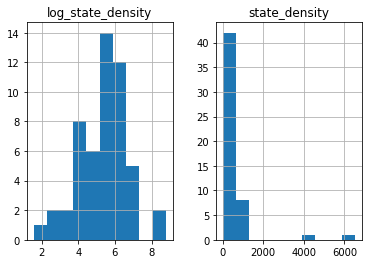

In [20]:
hist = state_densities.hist()

In [21]:
state_densities.sort_values(by=['state_density'], inplace=True)

highest_density = state_densities.nlargest(1, 'log_state_density')
highest_density.values[0]

array(['New York', 6525.341291386587, 8.783448536016373], dtype=object)

In [22]:
# rho is the normalized avg_city_density index between 0 and 1 (1 being set by the most dense state)
state_densities['propotionate_log_density'] = state_densities['log_state_density'] / highest_density.values[0][2]
state_densities.reset_index(drop=True, inplace=True)
state_densities.head(5)

state  state_density  log_state_density  propotionate_log_density
0       Wyoming       4.784258           1.565331                  0.178214
1       Montana      10.657449           2.366259                  0.269400
2  North Dakota      16.302211           2.791301                  0.317791
3  South Dakota      27.960124           3.330779                  0.379211
4        Alaska      28.190256           3.338976                  0.380144

In [23]:
state_densities

state  state_density  log_state_density  \
0                Wyoming       4.784258           1.565331   
1                Montana      10.657449           2.366259   
2           North Dakota      16.302211           2.791301   
3           South Dakota      27.960124           3.330779   
4                 Alaska      28.190256           3.338976   
5                Vermont      47.229270           3.855014   
6            Mississippi      53.482931           3.979363   
7                  Maine      61.158102           4.113462   
8          West Virginia      63.188820           4.146127   
9               Arkansas      66.648161           4.199427   
10                 Idaho      72.442735           4.282796   
11            New Mexico      81.935939           4.405938   
12                Nevada      84.412301           4.435713   
13                  Iowa      88.888785           4.487386   
14               Alabama      91.937932           4.521114   
15        South Carolina     118.396761           4.774041   
16               Arizona     118.855999           4.777913   
17         New Hampshire     121.827545           4.802606   
18                Kansas     174.915455           5.164303   
19              Oklahoma     185.049932           5.220626   
20            Washington     204.370575           5.319935   
21             Tennessee     208.165428           5.338333   
22                Oregon     213.135175           5.361927   
23             Louisiana     220.290428           5.394947   
24              Kentucky     222.773685           5.406156   
25        North Carolina     242.339481           5.490340   
26              Nebraska     247.796517           5.512608   
27               Indiana     253.912452           5.536990   
28                  Utah     303.037839           5.713858   
29              Missouri     330.791730           5.801489   
30              Delaware     336.101691           5.817414   
31             Wisconsin     341.648435           5.833782   
32              Colorado     349.522827           5.856569   
33               Florida     389.002804           5.963587   
34               Georgia     393.226848           5.974387   
35             Minnesota     399.923377           5.991273   
36              Michigan     403.192494           5.999414   
37                  Ohio     407.236112           6.009393   
38           Connecticut     435.244606           6.075908   
39                Hawaii     452.241924           6.114217   
40                 Texas     490.189950           6.194793   
41          Rhode Island     496.014837           6.206606   
42              Virginia     691.538889           6.538919   
43            California     709.933780           6.565172   
44              Maryland     736.824810           6.602350   
45           Puerto Rico     817.266589           6.705965   
46          Pennsylvania     825.399967           6.715868   
47         Massachusetts    1034.832971           6.941995   
48              Illinois    1046.866866           6.953557   
49            New Jersey    1296.931240           7.167756   
50  District of Columbia    4322.952569           8.371694   
51              New York    6525.341291           8.783449   

    propotionate_log_density  
0                   0.178214  
1                   0.269400  
2                   0.317791  
3                   0.379211  
4                   0.380144  
5                   0.438895  
6                   0.453052  
7                   0.468320  
8                   0.472039  
9                   0.478107  
10                  0.487599  
11                  0.501618  
12                  0.505008  
13                  0.510891  
14                  0.514731  
15                  0.543527  
16                  0.543968  
17                  0.546779  
18                  0.587958  
19                  0.594371  
20                  0.605677  
21                  0.607772  
22                 

In [24]:
weekly_est_cases_deaths.iloc[150:154,]

state       date  new_cases_jhu  new_deaths_jhu  \
150  Arkansas 2020-03-28            287               5   
151  Arkansas 2020-04-04            334               9   
152  Arkansas 2020-04-11            485              11   
153  Arkansas 2020-04-18            516              13   

     Excess Lower Estimate  Excess Higher Estimate  mid_point_xs_deaths  \
150                    0.0                     0.0                  0.0   
151                    0.0                     0.0                  0.0   
152                    0.0                     0.0                  0.0   
153                    0.0                     5.0                  2.5   

     corr_new_deaths  est_inf  pro_chg_est_inf  mobile_infectious       phi  \
150              5.0   1617.0           0.2222             1323.0  0.000438   
151              9.0   2279.0           0.4094             1617.0  0.000536   
152             11.0   1470.0          -0.3550             2279.0  0.000755   
153             15.5   3676.0           1.5007             1470.0  0.000487   

     population  
150     3017804  
151     3017804  
152     3017804  
153     3017804

In [25]:
# add est_inf/100,000 population

weekly_est_cases_deaths['est_inf_per_100k'] = weekly_est_cases_deaths['est_inf'] / (weekly_est_cases_deaths['population'] / 100000)

In [26]:
weekly_est_cases_deaths.head()

state       date  new_cases_jhu  new_deaths_jhu  Excess Lower Estimate  \
0  Alabama 2020-01-25              0               0                    0.0   
1  Alabama 2020-02-01              0               0                    0.0   
2  Alabama 2020-02-08              0               0                    0.0   
3  Alabama 2020-02-15              0               0                    0.0   
4  Alabama 2020-02-22              0               0                    0.0   

   Excess Higher Estimate  mid_point_xs_deaths  corr_new_deaths  est_inf  \
0                     0.0                  0.0              0.0      0.0   
1                     0.0                  0.0              0.0      0.0   
2                    10.0                  5.0              0.0      0.0   
3                     0.0                  0.0              0.0      0.0   
4                     5.0                  2.5              0.0      0.0   

   pro_chg_est_inf  mobile_infectious  phi  population  est_inf_per_100k  
0              NaN                NaN  NaN     4903185               0.0  
1              NaN                NaN  NaN     4903185               0.0  
2              NaN                NaN  NaN     4903185               0.0  
3              NaN                NaN  NaN     4903185               0.0  
4              NaN                NaN  NaN     4903185               0.0

In [27]:
# add the two letter state code to the df for plotting purposes

def state_id(row):
    state = row['state']
    state_id = state_abbrevs[state_abbrevs['State'] == state]['Code']
    return state_id.values[0]

weekly_est_cases_deaths['state_id'] =  weekly_est_cases_deaths.apply(state_id, axis=1)

In [28]:
def add_rho(row):
    state = row['state']
    rho = state_densities[state_densities['state'] == state]['propotionate_log_density']
    return rho.values[0]

weekly_est_cases_deaths['rho'] =  weekly_est_cases_deaths.apply(add_rho, axis=1)

weekly_est_cases_deaths.head(5)

state       date  new_cases_jhu  new_deaths_jhu  Excess Lower Estimate  \
0  Alabama 2020-01-25              0               0                    0.0   
1  Alabama 2020-02-01              0               0                    0.0   
2  Alabama 2020-02-08              0               0                    0.0   
3  Alabama 2020-02-15              0               0                    0.0   
4  Alabama 2020-02-22              0               0                    0.0   

   Excess Higher Estimate  mid_point_xs_deaths  corr_new_deaths  est_inf  \
0                     0.0                  0.0              0.0      0.0   
1                     0.0                  0.0              0.0      0.0   
2                    10.0                  5.0              0.0      0.0   
3                     0.0                  0.0              0.0      0.0   
4                     5.0                  2.5              0.0      0.0   

   pro_chg_est_inf  mobile_infectious  phi  population  est_inf_per_100k  \
0              NaN                NaN  NaN     4903185               0.0   
1              NaN                NaN  NaN     4903185               0.0   
2              NaN                NaN  NaN     4903185               0.0   
3              NaN                NaN  NaN     4903185               0.0   
4              NaN                NaN  NaN     4903185               0.0   

  state_id       rho  
0       AL  0.514731  
1       AL  0.514731  
2       AL  0.514731  
3       AL  0.514731  
4       AL  0.514731

In [29]:
mobility_data = pd.read_csv("data/Global_Mobility_Report.csv")

# drop non-US data
mobility_data.drop(mobility_data.loc[mobility_data['country_region_code'] != "US"].index, inplace=True)

# drop county data, only using state level data for this analysis
mobility_data = mobility_data[mobility_data['sub_region_2'].isna()]

# drop other unnecessary columns
mobility_data.drop(['country_region_code','country_region','iso_3166_2_code','census_fips_code','metro_area','sub_region_2'], axis=1, inplace=True)

# convert date column to datetime formate
mobility_data['date'] = pd.to_datetime(mobility_data['date'])

# there are values that are "US" but don't have a sub_region_1 - they're probably all US - drop these
mobility_data.dropna(subset=['sub_region_1'], inplace=True)

mobility_data.info()

/Users/robbdunlap/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 15147 entries, 2633320 to 3376598
Data columns (total 8 columns):
sub_region_1                                          15147 non-null object
date                                                  15147 non-null datetime64[ns]
retail_and_recreation_percent_change_from_baseline    15147 non-null float64
grocery_and_pharmacy_percent_change_from_baseline     15147 non-null float64
parks_percent_change_from_baseline                    14700 non-null float64
transit_stations_percent_change_from_baseline         15012 non-null float64
workplaces_percent_change_from_baseline               15147 non-null float64
residential_percent_change_from_baseline              15147 non-null float64
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 1.0+ MB


In [30]:
mobility_data.head(1)

sub_region_1       date  \
2633320      Alabama 2020-02-15   

         retail_and_recreation_percent_change_from_baseline  \
2633320                                                5.0    

         grocery_and_pharmacy_percent_change_from_baseline  \
2633320                                                2.0   

         parks_percent_change_from_baseline  \
2633320                                39.0   

         transit_stations_percent_change_from_baseline  \
2633320                                            7.0   

         workplaces_percent_change_from_baseline  \
2633320                                      2.0   

         residential_percent_change_from_baseline  
2633320                                      -1.0

In [31]:
mob_data_for_plotting = mobility_data.iloc[:,0:8]

mob_data_for_plotting.rename(columns={'retail_and_recreation_percent_change_from_baseline':'retail_pcfb',
                     'grocery_and_pharmacy_percent_change_from_baseline':'groc_pcfb',
                     'parks_percent_change_from_baseline':'parks_pcfb',
                     'transit_stations_percent_change_from_baseline':'transit_pcfb',
                     'workplaces_percent_change_from_baseline':'work_pcfb',
                     'residential_percent_change_from_baseline':'res_pcfb'}, inplace=True)

mob_data_for_plotting.head(1)

sub_region_1       date  retail_pcfb  groc_pcfb  parks_pcfb  \
2633320      Alabama 2020-02-15          5.0        2.0        39.0   

         transit_pcfb  work_pcfb  res_pcfb  
2633320           7.0        2.0      -1.0

In [32]:
# count the number of nan values in the mobility data
count_nan_mob_data_for_plotting = pd.DataFrame(mob_data_for_plotting[['retail_pcfb',
              'groc_pcfb',
              'parks_pcfb',
              'transit_pcfb',
              'work_pcfb',
              'res_pcfb']
             ].isnull().groupby(mob_data_for_plotting['sub_region_1']).sum())

# get rid of the decimals by converting to int
count_nan_mob_data_for_plotting = count_nan_mob_data_for_plotting.iloc[:,0:6].astype(dtype='int32')

# capture all records with any nan into a new df for display
count_of_nan = count_nan_mob_data_for_plotting[(count_nan_mob_data_for_plotting.iloc[:,0] != 0) | 
            (count_nan_mob_data_for_plotting.iloc[:,1] != 0) |
            (count_nan_mob_data_for_plotting.iloc[:,2] != 0) |
            (count_nan_mob_data_for_plotting.iloc[:,3] != 0) |
            (count_nan_mob_data_for_plotting.iloc[:,4] != 0) |
            (count_nan_mob_data_for_plotting.iloc[:,5] != 0)]

count_days_data = mob_data_for_plotting['date'].nunique()
print(f'Number of days of missing data in each activity bin by state out of {count_days_data} days of data')
count_of_nan

Number of days of missing data in each activity bin by state out of 297 days of data


retail_pcfb  groc_pcfb  parks_pcfb  transit_pcfb  work_pcfb  \
sub_region_1                                                                 
Alaska                   0          0          26            25          0   
Arkansas                 0          0           7             0          0   
Delaware                 0          0          65             6          0   
Idaho                    0          0          44             0          0   
Iowa                     0          0          22             0          0   
Kansas                   0          0          16             0          0   
Kentucky                 0          0           1             0          0   
Maine                    0          0          25            25          0   
Montana                  0          0          25             3          0   
Nebraska                 0          0          25             0          0   
New Hampshire            0          0          26            22          0   
North Dakota             0          0          35             0          0   
Rhode Island             0          0          27             0          0   
South Dakota             0          0          27            25          0   
Vermont                  0          0          26            25          0   
West Virginia            0          0          17             3          0   
Wyoming                  0          0          33             1          0   

               res_pcfb  
sub_region_1             
Alaska                0  
Arkansas              0  
Delaware              0  
Idaho                 0  
Iowa                  0  
Kansas                0  
Kentucky              0  
Maine                 0  
Montana               0  
Nebraska              0  
New Hampshire         0  
North Dakota          0  
Rhode Island          0  
South Dakota          0  
Vermont               0  
West Virginia         0  
Wyoming               0

In [33]:
# show the records with nan values. In general, the missing data by state are not sequential but distributed 
# throughout the range of dates as shown below. This is rationalization for filling by interpolating from 
# the prior and following values.
# mob_data_for_plotting_test = mob_data_for_plotting[mob_data_for_plotting.isna().any(axis=1)]
# mob_data_for_plotting_test.head(60)

In [34]:
# fill nan by interpolation
mobility_data.interpolate(method='linear', limit_direction='forward', axis=0, inplace=True)

# show how well the interpolation did in filling the nan values - drop this when integrating into moduleHi John
mob_data_for_plotting = mobility_data.iloc[:,0:8]

mob_data_for_plotting.rename(columns={'retail_and_recreation_percent_change_from_baseline':'retail_pcfb',
                     'grocery_and_pharmacy_percent_change_from_baseline':'groc_pcfb',
                     'parks_percent_change_from_baseline':'parks_pcfb',
                     'transit_stations_percent_change_from_baseline':'transit_pcfb',
                     'workplaces_percent_change_from_baseline':'work_pcfb',
                     'residential_percent_change_from_baseline':'res_pcfb'}, inplace=True)

# mob_data_for_plotting_test = mob_data_for_plotting[mob_data_for_plotting.isna().any(axis=1)]
# mob_data_for_plotting_test.head()

In [35]:
# List of state to use in the loop to process the data for each state
list_of_states = ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', \
                  'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', \
                  'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', \
                  'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', \
                  'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', \
                  'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']

#create an empty df to receive the processed data
df_columns = [
 'sub_region_1',
 'date',
 'retail_and_recreation_percent_change_from_baseline',
 'grocery_and_pharmacy_percent_change_from_baseline',
 'parks_percent_change_from_baseline',
 'transit_stations_percent_change_from_baseline',
 'workplaces_percent_change_from_baseline',
 'residential_percent_change_from_baseline',
 'retail_and_recreation_percent_change_from_baseline_rolling_avg',
 'grocery_and_pharmacy_percent_change_from_baseline_rolling_avg',
 'parks_percent_change_from_baseline_rolling_avg',
 'transit_stations_percent_change_from_baseline_rolling_avg',
 'workplaces_percent_change_from_baseline_rolling_avg',
 'residential_percent_change_from_baseline_rolling_avg',
 'retail_n_rec_normal_exp_per_day',
 'groc_n_pharm_normal_exp_per_day',
 'parks_normal_exp_per_day',
 'trans_stat_normal_exp_per_day',
 'work_normal_exp_per_day',
 'res_normal_exp_per_day',
 'normal_exposure_per_day',]
all_state_mob_data = pd.DataFrame(columns = df_columns)
all_state_mob_data['date'] = pd.to_datetime(all_state_mob_data['date'])

# loop through the data to process the data for each state
for state_selected in list_of_states:
    
    # subselect state data
    state_mob_data = mobility_data.drop(mobility_data.loc[mobility_data['sub_region_1'] \
                                         != state_selected].index)
        
    # subselect just the data from the state that doesn't have a county listed 
    #state_mobility_data = state_mob_data[state_mob_data['sub_region_2'].isna()]
    
    # create an explicit copy of the dataframe to avoid the "A value is trying to be set on a copy of a slice from 
    # a DataFrame." Pandas warning
    state_mobility_data = state_mob_data.copy()
    
    # calculate a rolling 7-day average for the 'precent change columns'
    column_titles = ['retail_and_recreation_percent_change_from_baseline', \
                    'grocery_and_pharmacy_percent_change_from_baseline', \
                    'parks_percent_change_from_baseline', \
                    'transit_stations_percent_change_from_baseline', \
                    'workplaces_percent_change_from_baseline', \
                    'residential_percent_change_from_baseline']
    for cat_item in column_titles:
        column_title = cat_item + '_rolling_avg'
        state_mobility_data[column_title] = \
        state_mobility_data[cat_item].rolling(window=7, center=False).mean()
        
    # the values in the embedded lists in the dictionary are "column titles" of the locations in state_mobility_data, 
    # baseline hours spent in those locations, exposure rates (exposures/hour) in those locations under "normal" conditions
   
    column_name_dict = {
            "retail_n_rec": ['retail_and_recreation_percent_change_from_baseline', 1, 50], 
            "groc_n_pharm": ['grocery_and_pharmacy_percent_change_from_baseline', 1, 100],
            "parks": ['parks_percent_change_from_baseline', 0.25, 4],
            "trans_stat": ['transit_stations_percent_change_from_baseline', 0.25, 20],
            "work": ['workplaces_percent_change_from_baseline', 8.75, 20],
            "res": ['residential_percent_change_from_baseline', 12.75, 0.1]
            }
    
    # calculate the daily exposure for the average person in each 'location' bucket under "normal" conditions
    for item in column_name_dict:
        new_column_title = item + '_normal_exp_per_day'
        mobility_column = column_name_dict[item][0]
        baseline_hours = column_name_dict[item][1]
        exposure_rate = column_name_dict[item][2]
   
        # The hours that the individual spends goes up or down by the percentage change indicated by the mobility index. 
        # The exposure rate also changes by the same proportion because there are commesurately more or less people in
        # the space, thus increasing or decreasing the exposure rate
        state_mobility_data[new_column_title] = \
        ((state_mobility_data[mobility_column]/100 * baseline_hours) + baseline_hours) * \
        (exposure_rate * (1 + state_mobility_data[mobility_column]/100))
    
    # sum the exposure buckets for "normal" conditions
    sum_column = state_mobility_data['retail_n_rec_normal_exp_per_day'] + state_mobility_data['groc_n_pharm_normal_exp_per_day'] + \
    state_mobility_data['parks_normal_exp_per_day'] + state_mobility_data['trans_stat_normal_exp_per_day'] + \
    state_mobility_data['work_normal_exp_per_day'] + state_mobility_data['res_normal_exp_per_day']

    state_mobility_data['normal_exposure_per_day'] = sum_column
    
    all_state_mob_data = all_state_mob_data.append(state_mobility_data, ignore_index = True)
    
    # drop intermediate dfs each loop
    del state_mob_data
    del state_mobility_data
    
    # Need the spaces to overwrite characters from longer names when followed by shorter names
    print('Finished', state_selected,'                         ', end='\r')

print('All Done!                                    ', end='\r')
#all_state_mob_data.drop('sub_region_2', axis=1, inplace=True)

# write the data out in case it's useful for something else
all_state_mob_data.to_csv("data/all_state_mob_data.csv", index=False)

# extracting latest date of GMD data for informing the viewer how current the data is
latest_date_of_GMD = all_state_mob_data.nlargest(1, 'date')
most_recent_GMD_data = str(latest_date_of_GMD.values[0][0])[:10]

# drop extraneous columns
for_weekly_mob_calc = all_state_mob_data.drop(["groc_n_pharm_normal_exp_per_day", 
                                 "grocery_and_pharmacy_percent_change_from_baseline",
                                 "grocery_and_pharmacy_percent_change_from_baseline_rolling_avg", 
                                 "parks_normal_exp_per_day", 
                                 "parks_percent_change_from_baseline", 
                                 "parks_percent_change_from_baseline_rolling_avg", 
                                 "res_normal_exp_per_day", 
                                 "retail_and_recreation_percent_change_from_baseline",
                                 "retail_and_recreation_percent_change_from_baseline_rolling_avg",
                                 "retail_n_rec_normal_exp_per_day",
                                 "trans_stat_normal_exp_per_day",
                                 "transit_stations_percent_change_from_baseline",
                                 "transit_stations_percent_change_from_baseline_rolling_avg",
                                 "work_normal_exp_per_day",
                                 "workplaces_percent_change_from_baseline",
                                 "workplaces_percent_change_from_baseline_rolling_avg",
                                 "residential_percent_change_from_baseline",
                                 "residential_percent_change_from_baseline_rolling_avg"], axis=1)

for_weekly_mob_calc['date'] =  pd.to_datetime(for_weekly_mob_calc['date'])

# for_weekly_mob_calc.set_index('date', inplace=True)

# sum the weekly mobility data, match the week starting date to the one used by the CDC
weekly_mobility_data = for_weekly_mob_calc.groupby('sub_region_1').resample('W-SAT', on='date').sum()
weekly_mobility_data.rename(columns={'normal_exposure_per_day':'weekly_expousres'}, inplace=True)

latest_date_of_GMD = for_weekly_mob_calc['date'].max()

weekly_mobility_data.reset_index(inplace=True)

# delete the lastest week if it's not a complete week
if latest_date_of_GMD.weekday() != 5:
    latest_date_of_weekly_mob_data = weekly_mobility_data.date.max()
    weekly_mobility_data = weekly_mobility_data[weekly_mobility_data.date != latest_date_of_weekly_mob_data]
    

###### add percent change in weekly exposures ######

def per_change_mobility_func(rows):
    # temporarily set panda options so that values with "divide by 0" are converted to nan instead of infinity
    with pd.option_context('mode.use_inf_as_na', True):
        rows['pro_chg_weekly_expousres'] = (rows['weekly_expousres'] - rows['weekly_expousres'].shift(1)) / rows['weekly_expousres'].shift(1)    
        return rows

weekly_mobility_data = weekly_mobility_data.groupby('sub_region_1').apply(per_change_mobility_func)

###### end/add percent change in weekly exposures ######

weekly_mobility_data.iloc[23:27,] 

sub_region_1       date  weekly_expousres  pro_chg_weekly_expousres
23      Alabama 2020-07-25       1736.614713                 -0.014830
24      Alabama 2020-08-01       1748.224120                  0.006685
25      Alabama 2020-08-08       1803.176820                  0.031433
26      Alabama 2020-08-15       1735.642870                 -0.037453

In [36]:
# merge the weekly_expousres data into the weekly_est_cases_deaths df
weekly_est_cases_deaths = weekly_est_cases_deaths.merge(weekly_mobility_data, left_on=['state','date'], right_on=['sub_region_1','date'], how='outer') 
del weekly_est_cases_deaths['sub_region_1']
weekly_est_cases_deaths.drop(weekly_est_cases_deaths[weekly_est_cases_deaths['date'] <= '2020-02-08' ].index, inplace=True)


In [37]:
weekly_est_cases_deaths.tail()

state       date  new_cases_jhu  new_deaths_jhu  \
2392  Wyoming 2020-11-14           5284              30   
2393  Wyoming 2020-11-21           5529              32   
2394  Wyoming 2020-11-28           4518              39   
2395  Wyoming 2020-12-05           4013              51   
2396  Wyoming 2020-12-12           2966              55   

      Excess Lower Estimate  Excess Higher Estimate  mid_point_xs_deaths  \
2392                    0.0                     5.0                  2.5   
2393                    0.0                     4.0                  2.0   
2394                    0.0                     0.0                  0.0   
2395                    NaN                     NaN                  NaN   
2396                    NaN                     NaN                  NaN   

      corr_new_deaths  est_inf  pro_chg_est_inf  mobile_infectious       phi  \
2392             32.5   5735.0           0.1470             5000.0  0.008639   
2393             34.0   7794.0           0.3590             5735.0  0.009909   
2394             39.0   8382.0           0.0754             7794.0  0.013467   
2395             53.0      NaN              NaN             8382.0  0.014483   
2396             57.0      NaN              NaN                NaN       NaN   

      population  est_inf_per_100k state_id       rho  weekly_expousres  \
2392      578759        990.913316       WY  0.178214       1663.969192   
2393      578759       1346.674523       WY  0.178214       1737.349582   
2394      578759       1448.271215       WY  0.178214       1493.435970   
2395      578759               NaN       WY  0.178214       1801.773408   
2396      578759               NaN       WY  0.178214               NaN   

      pro_chg_weekly_expousres  
2392                 -0.106627  
2393                  0.044100  
2394                 -0.140394  
2395                  0.206462  
2396                       NaN

In [38]:
# density correction of exposure rate
weekly_est_cases_deaths['density_cor_expousre'] = weekly_est_cases_deaths['weekly_expousres'] * weekly_est_cases_deaths['rho']


# calculate Psi
prob_actual_exposure_to_disease = 0.01

def add_psi(row):
    if ((row['density_cor_expousre'] == 0) or (row['mobile_infectious'] == 0) or 
        (row['rho'] == 0) or (row['est_inf'] == 0)):
        return np.nan
    elif isnan(row['density_cor_expousre'] or row['mobile_infectious'] or row['rho'] or row['est_inf']):
        return np.nan
    else:
        psi = (row['est_inf']/(row['density_cor_expousre'] * row['mobile_infectious'] * prob_actual_exposure_to_disease))
        return psi

weekly_est_cases_deaths["psi"] = weekly_est_cases_deaths.apply(add_psi, axis=1)


In [39]:
state = 'New Mexico'

corr_matrix = weekly_est_cases_deaths[(weekly_est_cases_deaths['state'] == state)].copy()

corr_matrix = corr_matrix[['est_inf', 'density_cor_expousre','mobile_infectious', 'psi', 'pro_chg_est_inf','pro_chg_weekly_expousres','pro_chg_est_inf']]

corr_matrix.corr()


est_inf  density_cor_expousre  mobile_infectious  \
est_inf                   1.000000             -0.350279           0.894986   
density_cor_expousre     -0.350279              1.000000          -0.338215   
mobile_infectious         0.894986             -0.338215           1.000000   
psi                      -0.119787              0.191048          -0.271170   
pro_chg_est_inf          -0.155434              0.338455          -0.277204   
pro_chg_weekly_expousres -0.199429              0.348180           0.167171   
pro_chg_est_inf          -0.155434              0.338455          -0.277204   

                               psi  pro_chg_est_inf  pro_chg_weekly_expousres  \
est_inf                  -0.119787        -0.155434                 -0.199429   
density_cor_expousre      0.191048         0.338455                  0.348180   
mobile_infectious        -0.271170        -0.277204                  0.167171   
psi                       1.000000         0.980905                 -0.456696   
pro_chg_est_inf           0.980905         1.000000                 -0.449529   
pro_chg_weekly_expousres -0.456696        -0.449529                  1.000000   
pro_chg_est_inf           0.980905         1.000000                 -0.449529   

                          pro_chg_est_inf  
est_inf                         -0.155434  
density_cor_expousre             0.338455  
mobile_infectious               -0.277204  
psi                              0.980905  
pro_chg_est_inf                  1.000000  
pro_chg_weekly_expousres        -0.449529  
pro_chg_est_inf                  1.000000

In [40]:
test = weekly_est_cases_deaths[(weekly_est_cases_deaths['state'] == state) & (weekly_est_cases_deaths['date'] > '2020-03-07')].copy()

corr_matrix_test = test[['est_inf', 'density_cor_expousre','mobile_infectious', 'psi', 'pro_chg_est_inf']]

test2 = corr_matrix_test.corr()
test2

est_inf  density_cor_expousre  mobile_infectious  \
est_inf               1.000000             -0.381171           0.894986   
density_cor_expousre -0.381171              1.000000          -0.338215   
mobile_infectious     0.894986             -0.338215           1.000000   
psi                  -0.119787              0.191048          -0.271170   
pro_chg_est_inf      -0.155434              0.338455          -0.277204   

                           psi  pro_chg_est_inf  
est_inf              -0.119787        -0.155434  
density_cor_expousre  0.191048         0.338455  
mobile_infectious    -0.271170        -0.277204  
psi                   1.000000         0.980905  
pro_chg_est_inf       0.980905         1.000000

In [41]:
# this is the code to generate a the correlation between 'density_cor_exposure with est_inf' and 'mobile_infections with est_inf'

corr_results_df = pd.DataFrame(columns = ['density_cor_expousre','mobile_infectious'])

corr_results_df.index.name = 'state'


for state in list_of_states:

    sub_select_dates_df = weekly_est_cases_deaths[(weekly_est_cases_deaths['state'] == state) & 
                                                  (weekly_est_cases_deaths['date'] > '2020-03-07')].copy()
    sub_select_dates_df = sub_select_dates_df[['est_inf', 'density_cor_expousre','mobile_infectious']]
    output_series = sub_select_dates_df.corr().loc['est_inf', ['density_cor_expousre','mobile_infectious']]

    output_series.rename(index=state, inplace=True)
    
    corr_results_df = corr_results_df.append(output_series)


corr_results_df.sort_values(by=['density_cor_expousre'], inplace=True)
corr_results_df

density_cor_expousre  mobile_infectious
state                                                        
Maryland                         -0.803912           0.847975
Connecticut                      -0.799614           0.892374
Massachusetts                    -0.798786           0.900790
Rhode Island                     -0.726525           0.624990
New Jersey                       -0.697142           0.919271
Pennsylvania                     -0.696465           0.860018
Delaware                         -0.638669           0.406552
Michigan                         -0.618733           0.853499
Illinois                         -0.589335           0.905942
District of Columbia             -0.550083           0.861729
New Hampshire                    -0.533182           0.673077
Colorado                         -0.498351           0.818872
Indiana                          -0.486489           0.887094
Louisiana                        -0.449852           0.827387
Virginia                         -0.436741           0.285968
Minnesota                        -0.426226           0.941193
New York                         -0.387247           0.861079
Maine                            -0.384576           0.773702
New Mexico                       -0.381171           0.894986
Vermont                          -0.329440           0.541315
Wyoming                          -0.324889           0.942115
Ohio                             -0.304262           0.819394
North Dakota                     -0.248211           0.922063
Mississippi                      -0.196500           0.776356
Alaska                           -0.196471           0.568916
North Carolina                   -0.174291           0.683372
Georgia                          -0.170407           0.618927
Missouri                         -0.164073           0.721927
South Dakota                     -0.148889           0.944500
Iowa                             -0.143918           0.897937
Arizona                          -0.143659           0.907302
California                       -0.141388           0.848043
Hawaii                           -0.140729           0.704627
Wisconsin                        -0.110481           0.898622
Oklahoma                         -0.108058           0.586246
Florida                          -0.078796           0.925515
Nebraska                         -0.076971           0.768328
West Virginia                    -0.062598           0.843300
Washington                       -0.051167          -0.038467
Montana                          -0.040412           0.917554
Kansas                           -0.040019           0.802930
Texas                            -0.037851           0.925384
Alabama                          -0.025231           0.674541
Arkansas                         -0.020678           0.766566
Kentucky                         -0.015507           0.494489
Utah                              0.012755           0.838300
Idaho                             0.041152           0.871455
Nevada                            0.076620           0.829174
Oregon                            0.094551           0.674450
South Carolina                    0.098683           0.868921
Tennessee                         0.161760           0.874407

In [42]:
# this is the code to generate a the correlation between 'pro_chg_est_inf' and 'per_chg_weekly_mob'

corr_results_df = pd.DataFrame(columns = ['pro_chg_weekly_expousres','mobile_infectious'])

corr_results_df.index.name = 'state'


for state in list_of_states:

    sub_select_dates_df = weekly_est_cases_deaths[(weekly_est_cases_deaths['state'] == state) & 
                                                  (weekly_est_cases_deaths['date'] > '2020-03-07')].copy()
    sub_select_dates_df = sub_select_dates_df[['pro_chg_est_inf', 'pro_chg_weekly_expousres','mobile_infectious','psi']]
    output_series = sub_select_dates_df.corr().loc['pro_chg_est_inf', ['pro_chg_weekly_expousres','mobile_infectious','psi']]

    output_series.rename(index=state, inplace=True)
    
    corr_results_df = corr_results_df.append(output_series)


corr_results_df.sort_values(by=['pro_chg_weekly_expousres'], inplace=True)
corr_results_df

pro_chg_weekly_expousres  mobile_infectious       psi
state                                                                      
Maryland                             -0.619384          -0.210083  0.997522
Illinois                             -0.612376          -0.267032  0.852351
Utah                                 -0.521019          -0.273265  0.988355
Iowa                                 -0.508104          -0.238922  0.912794
California                           -0.503107          -0.454165  0.768343
North Carolina                       -0.476196          -0.519418  0.991629
Rhode Island                         -0.474087          -0.279355  0.992304
New Mexico                           -0.449529          -0.277204  0.980905
Nevada                               -0.442121          -0.382551  0.938407
Kentucky                             -0.439023          -0.478213  0.985553
Texas                                -0.435706          -0.379910  0.802513
Kansas                               -0.406626          -0.317353  0.959946
Alabama                              -0.398080          -0.404406  0.997540
Maine                                -0.353869          -0.229216  0.973241
Minnesota                            -0.327877          -0.327822  0.946281
Florida                              -0.319407          -0.451941  0.670030
South Dakota                         -0.314887          -0.255313  0.927774
New Hampshire                        -0.265333          -0.415272  0.931608
Delaware                             -0.257126          -0.416317  0.957890
Ohio                                 -0.245477          -0.444723  0.903635
Missouri                             -0.233322          -0.381673  0.913391
Arizona                              -0.231852          -0.286009  0.974568
Pennsylvania                         -0.224968          -0.280986  0.937398
New York                             -0.224427          -0.133897  0.899775
Vermont                              -0.196522          -0.101489  0.803614
South Carolina                       -0.188260          -0.437210  0.905138
Georgia                              -0.168662          -0.530307  0.909441
Montana                              -0.160604          -0.194382  0.970370
New Jersey                           -0.133187          -0.010878  0.935273
Alaska                               -0.128140          -0.245870  0.996903
Washington                           -0.126932          -0.552309  0.929533
Mississippi                          -0.111227          -0.377480  0.998987
District of Columbia                 -0.103782          -0.217435  0.997132
Colorado                             -0.098083          -0.287198  0.924312
Tennessee                            -0.091158          -0.367206  0.982575
Nebraska                             -0.075860          -0.226673  0.996769
Idaho                                -0.074688          -0.238477  0.960912
Indiana                              -0.062694          -0.290754  0.986564
Connecticut                          -0.058777          -0.212157  0.981032
Oklahoma                             -0.056706          -0.323807  0.997287
Hawaii                               -0.054881          -0.218319  0.963967
North Dakota                         -0.034295          -0.262704  0.948397
Virginia                             -0.026799          -0.472759  0.987011
Massachusetts                        -0.025828          -0.158949  0.995653
Wisconsin                            -0.024835          -0.216145  0.947870
Louisiana                            -0.015882          -0.314323  0.977116
Michigan                              0.017984          -0.205595  0.998183
Oregon                                0.031878          -0.465074  0.925245
West Virginia                         0.054285          -0.276826  0.977858
Arkansas                              0.058049          -0.393301  0.961911
Wyoming                               0.253018          -0.178691  0.9

In [43]:
# this is the code to generate a the correlation between 'density_cor_exposure with est_inf' and 'mobile_infections with est_inf'

corr_results_df = pd.DataFrame(columns = ['density_cor_expousre','mobile_infectious'])

corr_results_df.index.name = 'state'


for state in list_of_states:

    sub_select_dates_df = weekly_est_cases_deaths[(weekly_est_cases_deaths['state'] == state) & 
                                                  (weekly_est_cases_deaths['date'] > '2020-03-07')].copy()
    sub_select_dates_df = sub_select_dates_df[['pro_chg_est_inf', 'density_cor_expousre','mobile_infectious']]
    output_series = sub_select_dates_df.corr().loc['pro_chg_est_inf', ['density_cor_expousre','mobile_infectious']]

    output_series.rename(index=state, inplace=True)
    
    corr_results_df = corr_results_df.append(output_series)


corr_results_df.sort_values(by=['density_cor_expousre'], inplace=True)
corr_results_df

density_cor_expousre  mobile_infectious
state                                                        
South Dakota                     -0.272333          -0.255313
Iowa                             -0.223442          -0.238922
West Virginia                    -0.065970          -0.276826
Arkansas                         -0.014367          -0.393301
Alaska                           -0.010056          -0.245870
North Dakota                      0.041160          -0.262704
Hawaii                            0.042012          -0.218319
New Hampshire                     0.046642          -0.415272
Maine                             0.079789          -0.229216
Nebraska                          0.099121          -0.226673
Rhode Island                      0.109319          -0.279355
Delaware                          0.121600          -0.416317
Illinois                          0.128207          -0.267032
Maryland                          0.132817          -0.210083
District of Columbia              0.139477          -0.217435
Utah                              0.142982          -0.273265
Texas                             0.156676          -0.379910
Wyoming                           0.172932          -0.178691
Idaho                             0.182821          -0.238477
Minnesota                         0.216736          -0.327822
Washington                        0.227067          -0.552309
Kentucky                          0.234723          -0.478213
Vermont                           0.280230          -0.101489
Montana                           0.281895          -0.194382
Connecticut                       0.282557          -0.212157
North Carolina                    0.306104          -0.519418
New Mexico                        0.338455          -0.277204
Alabama                           0.339895          -0.404406
New Jersey                        0.350610          -0.010878
Kansas                            0.375927          -0.317353
Ohio                              0.409816          -0.444723
California                        0.426103          -0.454165
Indiana                           0.434604          -0.290754
Michigan                          0.438317          -0.205595
Wisconsin                         0.443164          -0.216145
Oregon                            0.454424          -0.465074
Missouri                          0.459540          -0.381673
Nevada                            0.465188          -0.382551
South Carolina                    0.479459          -0.437210
Georgia                           0.488053          -0.530307
Pennsylvania                      0.506022          -0.280986
Mississippi                       0.544184          -0.377480
Oklahoma                          0.557355          -0.323807
Colorado                          0.564261          -0.287198
New York                          0.570448          -0.133897
Tennessee                         0.613737          -0.367206
Massachusetts                     0.629261          -0.158949
Florida                           0.645844          -0.451941
Virginia                          0.653678          -0.472759
Louisiana                         0.713364          -0.314323
Arizona                           0.765991          -0.286009

In [44]:
# CDC Test Positivity Rate
# https://healthdata.gov/dataset/covid-19-diagnostic-laboratory-testing-pcr-testing-time-series/resource/fe3c12ae-bdba-49eb#{}


test_positivity_df = pd.read_csv('data/covid_testing_data_filecovid-19_diagnostic_lab_testing.csv')
total_test_df = test_positivity_df.groupby(['state_name', 'date']).sum()
total_test_df.drop(total_test_df[['state_fips','total_results_reported']], axis=1, inplace=True)
positive_tests_df = test_positivity_df[test_positivity_df['overall_outcome']== 'Positive'].copy()
positive_tests_df.drop(positive_tests_df.columns[[0,2,3,4,7,]], axis=1, inplace=True)
positive_tests_df.rename(columns={'new_results_reported':'positive_results'}, inplace=True)
positive_tests_df
total_test_df = total_test_df.merge(positive_tests_df, left_on=['state_name', 'date'], right_on=['state_name', 'date'])

# calculate the daily test positivity result
total_test_df['test_positivity_rate'] = total_test_df['positive_results'] / total_test_df['new_results_reported']
total_test_df['date'] =  pd.to_datetime(total_test_df['date'])


total_test_weekly_df = total_test_df.groupby('state_name').resample('W-SAT', on='date').sum()

weekly_est_cases_deaths = weekly_est_cases_deaths.merge(total_test_weekly_df, left_on=['state','date'], right_on=['state_name', 'date'])
weekly_est_cases_deaths.head(2)

# save as csv for use by other modules
weekly_est_cases_deaths.to_csv('data/weekly_est_cases_deaths.csv', index=False)

In [45]:
# this is the code to generate a the correlation between 'density_cor_exposure with est_inf' and 'mobile_infections with est_inf'

# website - https://www.cdc.gov/covid-data-tracker/#testing

# api info https://healthdata.gov/node/3281126/api

test_post_corr_df = pd.DataFrame(columns = ['density_cor_expousre','test_positivity_rate'])

test_post_corr_df.index.name = 'state'


del sub_select_dates_df
del output_series

for state in list_of_states:

    sub_select_dates_df = weekly_est_cases_deaths[(weekly_est_cases_deaths['state'] == state) & 
                                                  (weekly_est_cases_deaths['date'] > '2020-03-07')].copy()
    sub_select_dates_df = sub_select_dates_df[['est_inf','test_positivity_rate', 'density_cor_expousre']]
    output_series = sub_select_dates_df.corr().loc['est_inf', ['test_positivity_rate','density_cor_expousre']]

    output_series.rename(index=state, inplace=True)
    
    test_post_corr_df = test_post_corr_df.append(output_series)


test_post_corr_df.sort_values(by=['test_positivity_rate'], ascending=False, inplace=True)
test_post_corr_df

density_cor_expousre  test_positivity_rate
state                                                           
New Jersey                       -0.822257              0.981232
Montana                          -0.040412              0.938766
District of Columbia             -0.550083              0.936561
Maryland                         -0.803912              0.935894
Connecticut                      -0.799614              0.921508
Louisiana                        -0.449852              0.912034
North Dakota                     -0.248211              0.911508
New York                         -0.387247              0.897926
New Mexico                       -0.381171              0.894013
Massachusetts                    -0.798786              0.881343
South Dakota                     -0.390575              0.872684
Idaho                             0.041152              0.871764
Michigan                         -0.618733              0.869918
Utah                              0.012755              0.845563
Wyoming                          -0.316477              0.804671
Arizona                          -0.143659              0.797234
Pennsylvania                     -0.696465              0.793179
Oklahoma                         -0.108058              0.763129
Missouri                         -0.164073              0.761028
Illinois                         -0.589335              0.743613
Mississippi                      -0.196500              0.742672
Rhode Island                     -0.763986              0.729109
Delaware                         -0.638669              0.714803
Alaska                           -0.196471              0.709840
Wisconsin                        -0.110481              0.701962
West Virginia                     0.012860              0.695210
Minnesota                        -0.426226              0.674520
Nevada                            0.076620              0.667451
Texas                            -0.037851              0.637525
Hawaii                           -0.140729              0.635268
Kansas                           -0.040019              0.631322
Iowa                             -0.143918              0.616391
Alabama                          -0.025231              0.609846
Ohio                             -0.304262              0.578831
Nebraska                         -0.076971              0.519690
Indiana                          -0.486489              0.498928
Oregon                            0.094551              0.491664
Florida                          -0.078796              0.485211
New Hampshire                    -0.533182              0.455666
Tennessee                         0.161760              0.444702
Maine                            -0.384576              0.394973
Vermont                          -0.460228              0.368478
Virginia                         -0.436741              0.288922
California                       -0.141388              0.213078
Washington                       -0.051167              0.211329
Colorado                         -0.524120              0.187041
Arkansas                         -0.020678              0.154267
Georgia                          -0.170407              0.100952
South Carolina                    0.098683              0.079418
Kentucky                         -0.015507             -0.102655
North Carolina                   -0.174291             -0.429589

In [46]:
weekly_est_cases_deaths.loc[weekly_est_cases_deaths['state'] == 'Alabama', 'pro_chg_est_inf']

0         inf
1     17.3810
2     -0.2245
3      0.3070
4      0.0000
5      0.4296
6      0.1644
7     -0.0565
8     -0.1368
9     -0.3168
10     0.7753
11    -0.0449
12    -0.3504
13     0.5922
14     0.2851
15     0.4116
16     0.1913
17    -0.0688
18     0.0103
19     0.0447
20    -0.1810
21    -0.0546
22    -0.1256
23     0.0574
24    -0.1304
25    -0.2344
26     0.0653
27    -0.5287
28     1.5122
29     0.1456
30    -0.4379
31     0.0904
32     0.4424
33     0.1310
34     0.1921
35    -0.4550
36     1.7653
37    -0.2516
38        NaN
39        NaN
Name: pro_chg_est_inf, dtype: float64

In [47]:
weekly_est_cases_deaths.groupby('state').pro_chg_est_inf.describe()

/Users/robbdunlap/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3949: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


count      mean        std     min       25%      50%  \
state                                                                         
Alabama                38.0       inf        NaN -0.5287 -0.135200  0.05105   
Alaska                 34.0       inf        NaN -1.0000 -0.596575  0.00000   
Arizona                39.0       inf        NaN -0.5190 -0.121750  0.11360   
Arkansas               38.0       inf        NaN -0.6876 -0.151900  0.13360   
California             39.0  1.130826   6.318330 -0.3985 -0.080300  0.05970   
Colorado               37.0  0.221281   0.610559 -0.6774 -0.250000  0.09190   
Connecticut            39.0       inf        NaN -0.9231 -0.345650  0.17300   
Delaware               38.0       inf        NaN -0.9422 -0.323275  0.17110   
District of Columbia   38.0       inf        NaN -0.8571 -0.395075  0.02205   
Florida                39.0  0.437113   1.861108 -0.3655 -0.129100  0.15000   
Georgia                39.0  0.752808   3.635899 -0.5456 -0.122150 -0.01920   
Hawaii                 32.0       inf        NaN -1.0000 -0.536600  0.07280   
Idaho                  38.0       inf        NaN -0.6667 -0.225775  0.06805   
Illinois               39.0       inf        NaN -0.6399 -0.156300  0.09270   
Indiana                39.0       inf        NaN -0.3455 -0.116350  0.11200   
Iowa                   38.0       inf        NaN -0.4435 -0.173825  0.05405   
Kansas                 39.0  0.384846   0.966049 -0.7620 -0.154150  0.18580   
Kentucky               39.0       inf        NaN -0.5959 -0.226900  0.04140   
Louisiana              38.0  0.285134   1.562692 -0.4599 -0.119775 -0.02695   
Maine                  38.0       inf        NaN -1.0000 -0.440875  0.03570   
Maryland               38.0  1.080284   6.030044 -0.4123 -0.177825 -0.04310   
Massachusetts          39.0       inf        NaN -0.4491 -0.159950  0.05350   
Michigan               38.0  1.786124  10.231899 -0.6116 -0.219425  0.01310   
Minnesota              38.0  0.445445   1.302352 -0.6565 -0.072450  0.15295   
Mississippi            38.0  1.193832   6.808281 -0.4898 -0.124100  0.05560   
Missouri               39.0       inf        NaN -0.6253 -0.237750  0.11910   
Montana                36.0       inf        NaN -1.0000 -0.230450  0.01380   
Nebraska               38.0       inf        NaN -0.9412 -0.260800  0.10830   
Nevada                 39.0       inf        NaN -0.5455 -0.110700  0.04850   
New Hampshire          38.0       inf        NaN -1.0000 -0.388150  0.25535   
New Jersey             37.0 -0.160395   1.480258 -8.0027 -0.300400 -0.14230   
New Mexico             38.0       inf        NaN -0.4645 -0.143725  0.07380   
New York               39.0  2.286354  12.531098 -0.6843 -0.368450 -0.01280   
North Carolina         38.0       inf        NaN -0.3348 -0.133325  0.03680   
North Dakota           38.0       inf        NaN -0.8948 -0.267425  0.19455   
Ohio                   39.0       inf        NaN -0.5659 -0.116000  0.07960   
Oklahoma               39.0       inf        NaN -0.5539 -0.259100 -0.09870   
Oregon                 39.0       inf        NaN -0.7539 -0.208450  0.13370   
Pennsylvania           39.0       inf        NaN -0.4607 -0.187400  0.10900   
Rhode Island           37.0  1.117319   3.560796 -0.9317 -0.272700  0.28830   
South Carolina         39.0       inf        NaN -0.5028 -0.195600  0.04880   
South Dakota           32.0  0.270169   0.667315 -0.7819 -0.165025  0.10960   
Tennessee              39.0       inf        NaN -0.5833 -0.163300  0.07130   
Texas                  39.0       inf        NaN -0.3792 -0.060250  0.05430   
Utah                   38.0       inf        NaN -0.5898 -0.231550  0.08955   
Vermont                21.0       inf        NaN -1.0000 -0.600000  0.00000   
Virginia               39.0  0.928664   4.431999 -0.6598 -0.250250 -0.04870   
Washington             39.0  0.156387   0.622472 -1.1833 -0.281150  0.10760   
West Virginia          37.0       inf        NaN -1.0000 -0.250000  0.23

In [48]:
weekly_est_cases_deaths.tail()

state       date  new_cases_jhu  new_deaths_jhu  \
2045  Wyoming 2020-11-14           5284              30   
2046  Wyoming 2020-11-21           5529              32   
2047  Wyoming 2020-11-28           4518              39   
2048  Wyoming 2020-12-05           4013              51   
2049  Wyoming 2020-12-12           2966              55   

      Excess Lower Estimate  Excess Higher Estimate  mid_point_xs_deaths  \
2045                    0.0                     5.0                  2.5   
2046                    0.0                     4.0                  2.0   
2047                    0.0                     0.0                  0.0   
2048                    NaN                     NaN                  NaN   
2049                    NaN                     NaN                  NaN   

      corr_new_deaths  est_inf  pro_chg_est_inf  ...  est_inf_per_100k  \
2045             32.5   5735.0           0.1470  ...        990.913316   
2046             34.0   7794.0           0.3590  ...       1346.674523   
2047             39.0   8382.0           0.0754  ...       1448.271215   
2048             53.0      NaN              NaN  ...               NaN   
2049             57.0      NaN              NaN  ...               NaN   

      state_id       rho  weekly_expousres pro_chg_weekly_expousres  \
2045        WY  0.178214       1663.969192                -0.106627   
2046        WY  0.178214       1737.349582                 0.044100   
2047        WY  0.178214       1493.435970                -0.140394   
2048        WY  0.178214       1801.773408                 0.206462   
2049        WY  0.178214               NaN                      NaN   

      density_cor_expousre       psi  new_results_reported  positive_results  \
2045            296.542104  0.386792                 30508              4210   
2046            309.619495  0.438933                 38757              5429   
2047            266.150748  0.404073                 31852              4132   
2048            321.100703       NaN                 22898              3166   
2049                   NaN       NaN                 14467              1555   

      test_positivity_rate  
2045              1.035121  
2046              1.075558  
2047              0.925254  
2048              1.073096  
2049              0.601054  

[5 rows x 23 columns]

In [49]:
state1 = 'Utah'
state2 = 'Virginia'

for_plotting1 = weekly_est_cases_deaths[(weekly_est_cases_deaths['state'] == state1) & (weekly_est_cases_deaths['date'] > '2020-03-07')]
for_plotting2 = weekly_est_cases_deaths[(weekly_est_cases_deaths['state'] == state2) & (weekly_est_cases_deaths['date'] > '2020-03-07')]

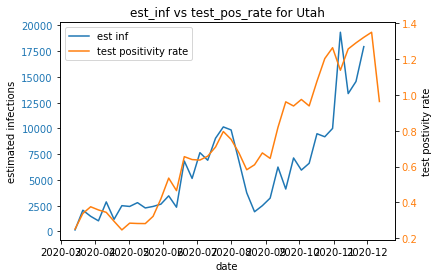

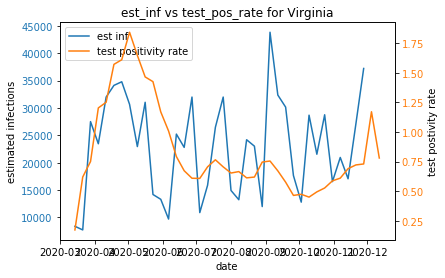

In [50]:
# set months to use to make sure dates in the graphs don't overlap (formatting issue)
months = mdates.MonthLocator()

# set format for x-axis
fmt = mdates.DateFormatter('%Y-%m')

color1 = 'tab:blue'
color2 = 'tab:orange'

# estimated infections vs. test positivity rate for state1
fig = plt.figure()
ax = fig.add_subplot(111)

lns1 = ax.plot(for_plotting1['date'], for_plotting1['est_inf'], '-', label='est inf', color=color1)
ax2 = ax.twinx()
lns2 = ax2.plot(for_plotting1['date'], for_plotting1['test_positivity_rate'], label='test positivity rate', color=color2)

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc='best')

ax.set_title(f'est_inf vs test_pos_rate for {state1}')
ax.set_xlabel('date')
ax.set_ylabel('estimated infections')
ax.tick_params(axis='y', labelcolor=color1)
ax2.set_ylabel('test postivity rate')
ax2.tick_params(axis='y', labelcolor=color2)

ax.xaxis.set_major_locator(months)
ax.format_xdata = fmt 

plt.show()



# estimated infections vs. test positivity rate for state2
fig = plt.figure()
ax = fig.add_subplot(111)

lns1 = ax.plot(for_plotting2['date'], for_plotting2['est_inf'], '-', label='est inf', color=color1)
ax2 = ax.twinx()
lns2 = ax2.plot(for_plotting2['date'], for_plotting2['test_positivity_rate'], label='test positivity rate', color=color2)

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc='best')

ax.set_title(f'est_inf vs test_pos_rate for {state2}')
ax.set_xlabel('date')
ax.set_ylabel('estimated infections')
ax.tick_params(axis='y', labelcolor=color1)
ax2.set_ylabel('test postivity rate')
ax2.tick_params(axis='y', labelcolor=color2)

ax.xaxis.set_major_locator(months)
ax.format_xdata = fmt 

plt.show()

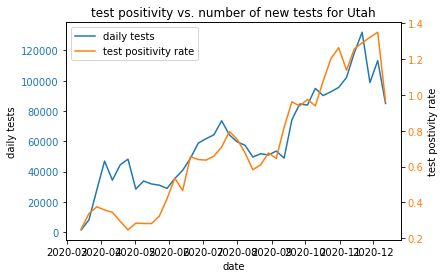

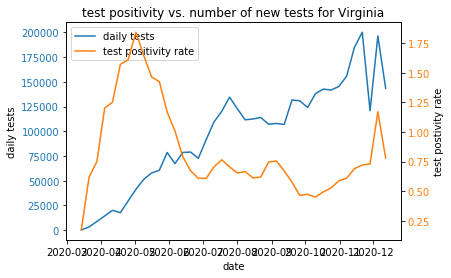

In [51]:
#### these figures show the correlation between the number of new tests administered weekly and the test positivity rate for those weeks

fig = plt.figure()
ax = fig.add_subplot(111)

lns1 = ax.plot(for_plotting1['date'], for_plotting1['new_results_reported'], '-', label='daily tests', color=color1)
ax2 = ax.twinx()
lns2 = ax2.plot(for_plotting1['date'], for_plotting1['test_positivity_rate'], label='test positivity rate', color=color2)

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc='best')

ax.set_title(f'test positivity vs. number of new tests for {state1}')
ax.set_xlabel('date')
ax.set_ylabel('daily tests')
ax.tick_params(axis='y', labelcolor=color1)
ax2.set_ylabel('test postivity rate')
ax2.tick_params(axis='y', labelcolor=color2)

ax.xaxis.set_major_locator(months)
ax.format_xdata = fmt 

plt.show()


fig = plt.figure()
ax = fig.add_subplot(111)

lns1 = ax.plot(for_plotting2['date'], for_plotting2['new_results_reported'], '-', label='daily tests', color=color1)
ax2 = ax.twinx()
lns2 = ax2.plot(for_plotting2['date'], for_plotting2['test_positivity_rate'], label='test positivity rate', color=color2)

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc='best')

ax.set_title(f'test positivity vs. number of new tests for {state2}')
ax.set_xlabel('date')
ax.set_ylabel('daily tests')
ax.tick_params(axis='y', labelcolor=color1)
ax2.set_ylabel('test postivity rate')
ax2.tick_params(axis='y', labelcolor=color2)

ax.xaxis.set_major_locator(months)
ax.format_xdata = fmt 

plt.show()

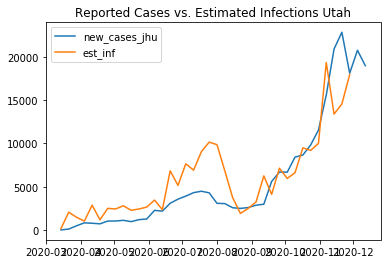

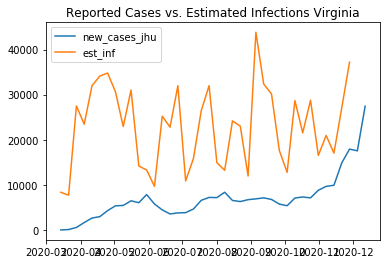

In [52]:

plt.plot('date', 'new_cases_jhu', data = for_plotting1, label='new_cases_jhu')
plt.plot('date', 'est_inf', data = for_plotting1, label='est_inf')
plt.legend(loc="best")
X = plt.gca().xaxis
X.set_major_locator(months)
# Specify formatter
X.set_major_formatter(fmt)
plt.title(f'Reported Cases vs. Estimated Infections {state1}')
plt.show()


plt.plot('date', 'new_cases_jhu', data = for_plotting2, label='new_cases_jhu')
plt.plot('date', 'est_inf', data = for_plotting2, label='est_inf')
plt.legend(loc="best")
X = plt.gca().xaxis
X.set_major_locator(months)
# Specify formatter
X.set_major_formatter(fmt)
plt.title(f'Reported Cases vs. Estimated Infections {state2}')
plt.show()
plt.show()

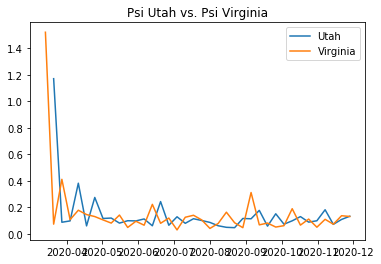

In [53]:
plt.plot('date', 'psi', data = for_plotting1, label=state1)
plt.plot('date', 'psi', data = for_plotting2, label=state2)
plt.legend(loc="upper right")
X = plt.gca().xaxis
X.set_major_locator(months)
# Specify formatter
X.set_major_formatter(fmt)
plt.title(f'Psi {state1} vs. Psi {state2}')
plt.show()

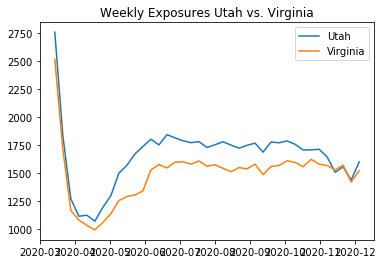

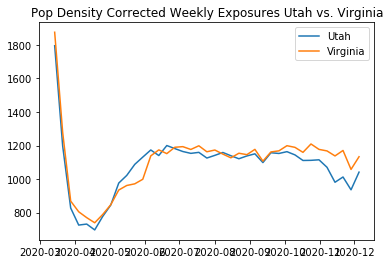

In [54]:
plt.plot('date', 'weekly_expousres', data = for_plotting1, label=state1)
plt.plot('date', 'weekly_expousres', data = for_plotting2, label=state2)
plt.legend(loc="best")

X = plt.gca().xaxis
X.set_major_locator(months)
# Specify formatter
X.set_major_formatter(fmt)
plt.title(f'Weekly Exposures {state1} vs. {state2}')
plt.show()


plt.plot('date', 'density_cor_expousre', data = for_plotting1, label=state1)
plt.plot('date', 'density_cor_expousre', data = for_plotting2, label=state2)
plt.legend(loc="best")

X = plt.gca().xaxis
X.set_major_locator(months)
# Specify formatter
X.set_major_formatter(fmt)
plt.title(f'Pop Density Corrected Weekly Exposures {state1} vs. {state2}')

plt.show()

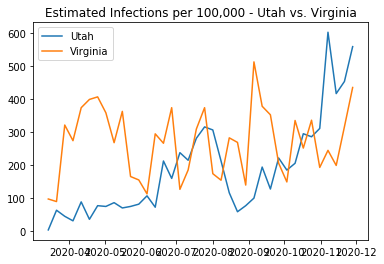

In [55]:
plt.plot('date', 'est_inf_per_100k', data = for_plotting1, label=state1)
plt.plot('date', 'est_inf_per_100k', data = for_plotting2, label=state2)
plt.legend(loc="best")

X = plt.gca().xaxis
X.set_major_locator(months)
X.set_major_formatter(fmt)
plt.title(f'Estimated Infections per 100,000 - {state1} vs. {state2}')
plt.show()

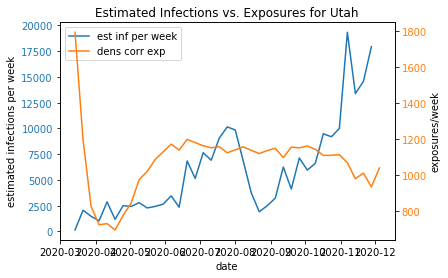

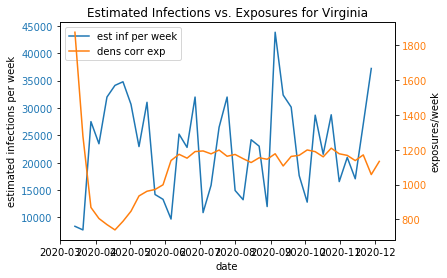

In [56]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

lns1 = ax1.plot(for_plotting1['date'], for_plotting1['est_inf'], '-', label='est inf per week', color=color1)
ax2 = ax1.twinx()
lns2 = ax2.plot(for_plotting1['date'], for_plotting1['density_cor_expousre'], label='dens corr exp', color=color2)

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='best')

ax1.set_xlabel('date')
ax1.set_ylabel('estimated infections per week')
ax1.tick_params(axis='y', labelcolor=color1)
ax2.set_ylabel('exposures/week')
ax2.tick_params(axis='y', labelcolor=color2)
ax1.xaxis.set_major_locator(months)
ax1.format_xdata = fmt

plt.title(f'Estimated Infections vs. Exposures for {state1}')
plt.show()


fig = plt.figure()
ax1 = fig.add_subplot(111)

lns1 = ax1.plot(for_plotting2['date'], for_plotting2['est_inf'], '-', label='est inf per week', color=color1)
ax2 = ax1.twinx()
lns2 = ax2.plot(for_plotting2['date'], for_plotting2['density_cor_expousre'], label='dens corr exp', color=color2)

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='best')

ax1.set_xlabel('date')
ax1.set_ylabel('estimated infections per week')
ax1.tick_params(axis='y', labelcolor=color1)
ax2.set_ylabel('exposures/week')
ax2.tick_params(axis='y', labelcolor=color2)
ax1.xaxis.set_major_locator(months)
ax1.format_xdata = fmt

plt.title(f'Estimated Infections vs. Exposures for {state2}')
plt.show()

Utah


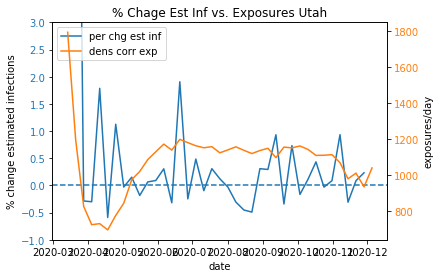

Virginia


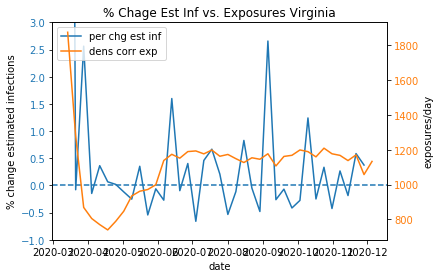

In [57]:
# for_plotting1 = weekly_est_cases_deaths[(weekly_est_cases_deaths['state'] == state1) & (weekly_est_cases_deaths['date'] > '2020-04-07')]
# for_plotting2 = weekly_est_cases_deaths[(weekly_est_cases_deaths['state'] == state2) & (weekly_est_cases_deaths['date'] > '2020-04-07')]

print(state1)
fig = plt.figure()
ax1 = fig.add_subplot(111)

lns1 = ax1.plot(for_plotting1['date'], for_plotting1['pro_chg_est_inf'], '-', label='per chg est inf', color=color1)
ax2 = ax1.twinx()
lns2 = ax2.plot(for_plotting1['date'], for_plotting1['density_cor_expousre'], label='dens corr exp', color=color2)

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='upper left')

ax1.set_xlabel('date')
ax1.set_ylabel('% change estimated infections')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.xaxis.set_major_locator(months)
ax1.format_xdata = fmt
ax1.set_ylim([-1,3])

ax2.set_ylabel('exposures/day')
ax2.tick_params(axis='y', labelcolor=color2)

ax1.axhline(y=0.0, color=color1, linestyle='--')
plt.title(f'% Chage Est Inf vs. Exposures {state1}')
plt.show()

print(state2)
fig = plt.figure()
ax1 = fig.add_subplot(111)

lns1 = ax1.plot(for_plotting2['date'], for_plotting2['pro_chg_est_inf'], '-', label='per chg est inf', color=color1)
ax2 = ax1.twinx()
lns2 = ax2.plot(for_plotting2['date'], for_plotting2['density_cor_expousre'], label='dens corr exp', color=color2)

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='upper left')

ax1.set_xlabel('date')
ax1.set_ylabel('% change estimated infections')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.xaxis.set_major_locator(months)
ax1.format_xdata = fmt
ax1.set_ylim([-1,3])

ax2.set_ylabel('exposures/day')
ax2.tick_params(axis='y', labelcolor=color2)

ax1.axhline(y=0.0, color=color1, linestyle='--')
plt.title(f'% Chage Est Inf vs. Exposures {state2}')
plt.show()

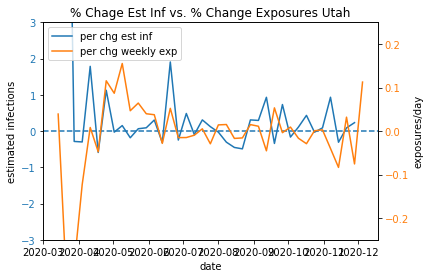

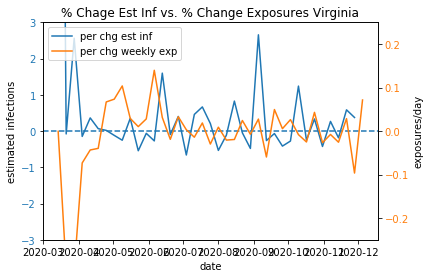

In [58]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

lns1 = ax1.plot(for_plotting1['date'], for_plotting1['pro_chg_est_inf'], '-', label='per chg est inf', color=color1)
ax2 = ax1.twinx()
lns2 = ax2.plot(for_plotting1['date'], for_plotting1['pro_chg_weekly_expousres'], label='per chg weekly exp', color=color2)

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='upper left')

ax1.set_xlabel('date')
ax1.set_ylabel('estimated infections')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.xaxis.set_major_locator(months)
ax1.format_xdata = fmt
ax1.set_ylim([-3,3])

ax2.set_ylabel('exposures/day')
ax2.tick_params(axis='y', labelcolor=color2)
ax2.set_ylim([-0.25,0.25])

ax1.axhline(y=0.0, color=color1, linestyle='--')
plt.title(f'% Chage Est Inf vs. % Change Exposures {state1}')
plt.show()


fig = plt.figure()
ax1 = fig.add_subplot(111)

lns1 = ax1.plot(for_plotting2['date'], for_plotting2['pro_chg_est_inf'], '-', label='per chg est inf', color=color1)
ax2 = ax1.twinx()
lns2 = ax2.plot(for_plotting2['date'], for_plotting2['pro_chg_weekly_expousres'], label='per chg weekly exp', color=color2)

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='upper left')

ax1.set_xlabel('date')
ax1.set_ylabel('estimated infections')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.xaxis.set_major_locator(months)
ax1.format_xdata = fmt
ax1.set_ylim([-3,3])

ax2.set_ylabel('exposures/day')
ax2.tick_params(axis='y', labelcolor=color2)
ax2.set_ylim([-0.25,0.25])

ax1.axhline(y=0.0, color=color1, linestyle='--')
plt.title(f'% Chage Est Inf vs. % Change Exposures {state2}')
plt.show()

In [59]:
# experiment to sum all cases in the use by date

In [60]:
weekly_est_cases_deaths.head(3)

state       date  new_cases_jhu  new_deaths_jhu  Excess Lower Estimate  \
0  Alabama 2020-03-14             15               0                    0.0   
1  Alabama 2020-03-21            134               0                    0.0   
2  Alabama 2020-03-28            652               4                    0.0   

   Excess Higher Estimate  mid_point_xs_deaths  corr_new_deaths  est_inf  \
0                    25.0                 12.5              0.0    588.0   
1                     0.0                  0.0              0.0  10808.0   
2                     0.0                  0.0              4.0   8382.0   

   pro_chg_est_inf  ...  est_inf_per_100k  state_id       rho  \
0              inf  ...         11.992205        AL  0.514731   
1          17.3810  ...        220.428150        AL  0.514731   
2          -0.2245  ...        170.950107        AL  0.514731   

   weekly_expousres pro_chg_weekly_expousres  density_cor_expousre       psi  \
0       2690.527010                 0.039724           1384.897795       NaN   
1       2057.852757                -0.235149           1059.240712  1.735295   
2       1412.825010                -0.313447            727.224902  0.106643   

   new_results_reported  positive_results  test_positivity_rate  
0                   637                17              0.049375  
1                  6286               312              0.361630  
2                 14307              1518              0.750093  

[3 rows x 23 columns]

In [61]:
weekly_est_cases_deaths.date.unique()

array(['2020-03-14T00:00:00.000000000', '2020-03-21T00:00:00.000000000',
       '2020-03-28T00:00:00.000000000', '2020-04-04T00:00:00.000000000',
       '2020-04-11T00:00:00.000000000', '2020-04-18T00:00:00.000000000',
       '2020-04-25T00:00:00.000000000', '2020-05-02T00:00:00.000000000',
       '2020-05-09T00:00:00.000000000', '2020-05-16T00:00:00.000000000',
       '2020-05-23T00:00:00.000000000', '2020-05-30T00:00:00.000000000',
       '2020-06-06T00:00:00.000000000', '2020-06-13T00:00:00.000000000',
       '2020-06-20T00:00:00.000000000', '2020-06-27T00:00:00.000000000',
       '2020-07-04T00:00:00.000000000', '2020-07-11T00:00:00.000000000',
       '2020-07-18T00:00:00.000000000', '2020-07-25T00:00:00.000000000',
       '2020-08-01T00:00:00.000000000', '2020-08-08T00:00:00.000000000',
       '2020-08-15T00:00:00.000000000', '2020-08-22T00:00:00.000000000',
       '2020-08-29T00:00:00.000000000', '2020-09-05T00:00:00.000000000',
       '2020-09-12T00:00:00.000000000', '2020-09-19

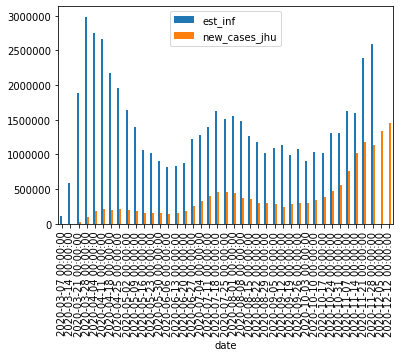

In [62]:
# Total estimated US cases vs. reported in JHU data
weekly_est_cases_deaths[['est_inf','new_cases_jhu']].groupby(weekly_est_cases_deaths['date']).sum().plot(kind='bar')
#print(test)